### Domain:
 Semiconductor manufacturing process
 
### CONTEXT:
A complex modern semiconductor manufacturing process is normally under constant surveillance via the monitoring of signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise.Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs. These signals can be used as features to predict the yield type. And by analysing and trying out different combinations of features, essential signals that are impacting the yield type can be identified.

### PROJECT OBJECTIVE:
We will build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all the features are required to build the model or not.

In [46]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, randint as sp_randint, uniform as sp_uniform

# Scikit-learn imports for preprocessing, models, metrics, and model selection
from sklearn.preprocessing import binarize, StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, f1_score,precision_recall_fscore_support)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score, KFold,RandomizedSearchCV, GridSearchCV,LeaveOneOut)
from sklearn.pipeline import make_pipeline

# Additional classifiers
from xgboost import XGBClassifier

# Imbalanced-learn imports for handling imbalanced datasets
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Setting up the visual aesthetics of seaborn
sns.set(color_codes=True)

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


### EDA and Data Pre-processing

### 1.Import and understand the data

In [47]:
#1A : Import ‘signal-data.csv’ as DataFrame.

signal_df = pd.read_csv(r'/Users/sneh/Documents/FMT /signal-data.csv')
signal_df.head()

Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045  99.3032   

      586     587     588       589  Pass/Fail  
0     NaN     NaN     NaN       NaN         -1  
1  0.0096  0.0201  0.0060  208.2045         -1  
2  0.0584  0.0484  0.0148   82.8602          1  
3  0.0202  0.0149  0.0044   73.8432         -1  
4  0.0202  0.0149  0.0044   73.8432         -1  

[5 rows x 592 columns]

In [48]:
# Print shape of the dataframe
signal_df.shape

(1567, 592)

In [49]:
#1B: Print 5 point summary and share at least 2 observations
summary = signal_df.describe().T
print(summary)


            count         mean         std        min          25%        50%  \
0          1561.0  3014.452896   73.621787  2743.2400  2966.260000  3011.4900   
1          1560.0  2495.850231   80.407705  2158.7500  2452.247500  2499.4050   
2          1553.0  2200.547318   29.513152  2060.6600  2181.044400  2201.0667   
3          1553.0  1396.376627  441.691640     0.0000  1081.875800  1285.2144   
4          1553.0     4.197013   56.355540     0.6815     1.017700     1.3168   
...           ...          ...         ...        ...          ...        ...   
586        1566.0     0.021458    0.012358    -0.0169     0.013425     0.0205   
587        1566.0     0.016475    0.008808     0.0032     0.010600     0.0148   
588        1566.0     0.005283    0.002867     0.0010     0.003300     0.0046   
589        1566.0    99.670066   93.891919     0.0000    44.368600    71.9005   
Pass/Fail  1567.0    -0.867262    0.498010    -1.0000    -1.000000    -1.0000   

                 75%       


OBSERVATIONS:

1.The data is not scaled across different sensors. Some sensors have higher reading while other sensors have lower readings.

2.For each sensor, the data seems to be on the same scale. But the scale is still different from one sensor to another.

### 2. Data cleansing:

In [50]:
# 2A. Write a for loop which will remove all the features with 20%+ Null values and impute rest with mean of the feature.

# Check which columns have null values
signal_df.columns[signal_df.isnull().any()].tolist()





['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '118',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '

In [51]:
# Create copy of dataframe
signal_clean=signal_df

# Set the threshold for removing columns
threshold = 0.2

# Create a list to hold columns to drop
cols_to_drop = []

# For loop to find columns with more than 20% null values
for column in signal_clean.columns:
    null_fraction = signal_clean[column].isnull().mean()
    if null_fraction > threshold:
        cols_to_drop.append(column)

# Drop the columns
signal_clean.drop(columns=cols_to_drop, inplace=True)

# For loop to impute remaining missing values with the mean of the column
for column in signal_clean.columns:
    if signal_clean[column].isnull().any():
        signal_clean[column].fillna(signal_clean[column].mean(), inplace=True)

print(signal_clean)


                     Time        0        1          2          3       4  \
0     2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602   
1     2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294   
2     2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102   
3     2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204   
4     2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334   
...                   ...      ...      ...        ...        ...     ...   
1562  2008-10-16 15:13:00  2899.41  2464.36  2179.7333  3085.3781  1.4843   
1563  2008-10-16 20:49:00  3052.31  2522.55  2198.5667  1124.6595  0.8763   
1564  2008-10-17 05:26:00  2978.81  2379.78  2206.3000  1110.4967  0.8236   
1565  2008-10-17 06:01:00  2894.92  2532.01  2177.0333  1183.7287  1.5726   
1566  2008-10-17 06:07:00  2944.92  2450.76  2195.4444  2914.1792  1.5978   

          5         6       7         8  ...      577     582     583     5

In [53]:
# All missing values have been removed

# Check if any column has null values remaining
signal_clean.columns[signal_clean.isna().any()].tolist()

[]

In [54]:
# 2B.Identify and drop the features which are having same value for all the rows.

# Show duplicate rows in the dataframe
signal_clean[signal_clean.duplicated()]

Empty DataFrame
Columns: [Time, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, ...]
Index: []

[0 rows x 560 columns]

In [55]:
# Check for duplicate values in the dataframe
signal_clean.duplicated().any()

False

There are no duplicate values or rows in the dataframe. No treatment necessary.

In [61]:
#2C. Drop other features if required using relevant functional knowledge. Clearly justify the same.

# Drop time column as it will not contribute towards model building
# Time column only acts as an indicator - when were the signals from different sensors recorded
signal_clean1 = signal_clean.drop('Time',axis=1)
signal_clean1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 559 entries, 0 to Pass/Fail
dtypes: float64(558), int64(1)
memory usage: 6.7 MB


In [62]:
# check whether any of the columns has any value other than numeric 
# i.e. data is not corrupted such as a "?" instead of a number
signal_clean1[~signal_clean1.applymap(np.isreal).all(1)]

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, ...]
Index: []

[0 rows x 559 columns]

In [67]:
# Calculate the correlation matrix


# Sample code, assuming `signal_data_clean1` is a pre-defined DataFrame
# Calculate the correlation matrix
cor = signal_clean1.corr()

# Extract the lower triangle of the correlation matrix
cor.loc[:, :] = np.tril(cor, k=-1)

# Stack the correlation matrix and filter for highly correlated pairs
cor = cor.stack()
highly_correlated = cor[(cor > 0.90) | (cor < -0.90)].to_dict()

highly_correlated


{('27', '25'): 0.9803753833240895,
 ('36', '34'): -0.999999999705215,
 ('50', '46'): 0.9044818259166781,
 ('54', '53'): 0.9352211984898345,
 ('70', '66'): 0.9044609903388549,
 ('96', '94'): -0.9570098301742918,
 ('101', '98'): 0.9067879315108983,
 ('104', '99'): -0.989545429124828,
 ('105', '92'): -0.9888957525678773,
 ('106', '93'): -0.9912928531099835,
 ('123', '121'): 0.9422826497625347,
 ('127', '122'): 0.9620857011801841,
 ('140', '4'): 0.9999751247610734,
 ('148', '16'): 0.9702941014493074,
 ('152', '16'): 0.9775661160561906,
 ('152', '148'): 0.9910694582650632,
 ('154', '148'): 0.9396050560127637,
 ('164', '163'): 0.9248163707333444,
 ('165', '164'): 0.963662602553624,
 ('174', '172'): 0.9999998114016201,
 ('199', '196'): 0.9419809272931773,
 ('204', '67'): 0.9022307064188828,
 ('206', '74'): 0.9999999999999991,
 ('207', '196'): 0.9167918615124555,
 ('209', '74'): 1.0000000000000002,
 ('209', '206'): 0.9999999999999992,
 ('249', '114'): 0.9770501850466099,
 ('252', '117'): 0.986

In [64]:
# In the above dictionary, we have two keys which are the two features/columns 
# and one value which is the correlation between the two features/columns
# We need to extract the features from the keys 

# Empty Lists to store keys from dictionary
feature1 = []
feature2 = []

# Find feature names from keys in the dictionary and store in respective lists
for k1, k2 in temp.keys():
    feature1.append(k1)
    feature2.append(k2)

# Print names of Features
print(feature1)
print(' ')
print(feature2)

['27', '36', '50', '54', '70', '96', '101', '104', '105', '106', '123', '127', '140', '148', '152', '152', '154', '164', '165', '174', '199', '204', '206', '207', '209', '209', '249', '252', '270', '271', '272', '273', '274', '275', '275', '277', '278', '279', '280', '281', '282', '283', '283', '283', '283', '285', '286', '287', '287', '287', '287', '288', '289', '289', '289', '290', '291', '294', '295', '296', '297', '298', '298', '298', '299', '299', '299', '299', '300', '300', '300', '300', '300', '301', '302', '303', '304', '305', '306', '307', '307', '308', '309', '309', '309', '310', '311', '312', '317', '318', '319', '320', '321', '323', '324', '331', '332', '332', '332', '332', '333', '333', '334', '335', '335', '335', '336', '336', '336', '336', '336', '337', '338', '339', '339', '340', '340', '341', '341', '342', '342', '342', '343', '343', '343', '343', '343', '344', '347', '347', '347', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '359', '360

In [65]:
#Drop highly correlated features
signal_clean2 = signal_clean1.drop(feature1, axis = 1)
eda.df_info(signal_data_clean2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 364 entries, 0 to Pass/Fail
dtypes: float64(363), int64(1)
memory usage: 4.4 MB


In [69]:
# 2D. Check for multi-collinearity in the data and take necessary action.

# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function for calculating VIF values for each column
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

# Shape of the dataframe on which multicollinearity treatment is to be done
signal_clean2.shape

(1567, 364)

In [70]:

# Define Function to remove multi-collinearity
def remove_multicollinearity(df,vif_thresh=10):
    # Drop the target column Pass/Fail to avoid VIF calculation
    vif_data = df.iloc[:,:-1]
    # Calculate VIF for independent variables of dataframe
    vif_table = calc_vif(vif_data)
    # Find Maximum VIF value from the above table
    max_vif = vif_table[vif_table.VIF == vif_table.VIF.max()].iloc[0,1]
    # Find feature/column with maximum VIF value
    max_vif_feature = vif_table[vif_table.VIF == vif_table.VIF.max()].iloc[0,0]
    # Print Maximum VIF Value and Feature/Column
    print('Initial Max VIF',max_vif)
    print(' ')
    print('Initial Max VIF Feature to be dropped',max_vif_feature)
    # Dropping variables should be an iterative process starting with the variable having the largest VIF value 
    # because its trend is highly captured by other variables. 
    # Loop until maximum VIF value is lower than the VIF threshold
    while max_vif > vif_thresh:
        # Drop feature/column with maximum VIF value
        vif_data = vif_data.drop(max_vif_feature, axis=1)
        # Re-calculate VIF table of new dataframe from above step
        vif_table = calc_vif(vif_data)
        # Find feature/column with maximum VIF value
        max_vif = vif_table[vif_table.VIF == vif_table.VIF.max()].iloc[0,1]
        # Find feature/column with maximum VIF value
        max_vif_feature = vif_table[vif_table.VIF == vif_table.VIF.max()].iloc[0,0]
        
        if max_vif > vif_thresh:
            # Print Maximum VIF Value and Feature/Column
            print('Max VIF',max_vif)
            print(' ')
            print('Last VIF Feature Dropped',max_vif_feature)
            
        # Store the updated dataframe in a new variable
        signal_data_mulcorr_removed = vif_data
    return signal_data_mulcorr_removed
    
# Call Function
signal_data_mulcorr_removed = remove_multicollinearity(signal_clean2)

Initial Max VIF 2211.958794972736
 
Initial Max VIF Feature to be dropped 12
Max VIF 540.4823827842662
 
Last VIF Feature Dropped 46
Max VIF 359.7512936709569
 
Last VIF Feature Dropped 430
Max VIF 234.47212120178023
 
Last VIF Feature Dropped 45
Max VIF 152.3941153120543
 
Last VIF Feature Dropped 202
Max VIF 99.53659333941552
 
Last VIF Feature Dropped 62
Max VIF 71.81015010082938
 
Last VIF Feature Dropped 43
Max VIF 44.69474012685534
 
Last VIF Feature Dropped 201
Max VIF 39.215781427739635
 
Last VIF Feature Dropped 196
Max VIF 32.269125009131834
 
Last VIF Feature Dropped 25
Max VIF 31.568613112063222
 
Last VIF Feature Dropped 224
Max VIF 23.883903546868645
 
Last VIF Feature Dropped 147
Max VIF 23.7609396385018
 
Last VIF Feature Dropped 203
Max VIF 19.567896063451077
 
Last VIF Feature Dropped 139
Max VIF 18.867392685597448
 
Last VIF Feature Dropped 480
Max VIF 17.293212686208783
 
Last VIF Feature Dropped 94
Max VIF 16.939511492996875
 
Last VIF Feature Dropped 51
Max VIF 16

In [71]:
# Display new dataframe after multi-collinearity is removed
signal_data_mulcorr_removed

0        1          2          3       4      5         6       7  \
0     3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   97.6133  0.1242   
1     3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0  102.3433  0.1247   
2     2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   95.4878  0.1241   
3     2988.72  2479.90  2199.0333   909.7926  1.3204  100.0  104.2367  0.1217   
4     3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0  100.3967  0.1235   
...       ...      ...        ...        ...     ...    ...       ...     ...   
1562  2899.41  2464.36  2179.7333  3085.3781  1.4843  100.0   82.2467  0.1248   
1563  3052.31  2522.55  2198.5667  1124.6595  0.8763  100.0   98.4689  0.1205   
1564  2978.81  2379.78  2206.3000  1110.4967  0.8236  100.0   99.4122  0.1208   
1565  2894.92  2532.01  2177.0333  1183.7287  1.5726  100.0   98.7978  0.1213   
1566  2944.92  2450.76  2195.4444  2914.1792  1.5978  100.0   85.1011  0.1235   

             8         9  ...      565       570     571    572     573  \
0     1.500500  0.016200  ...  0.14561  533.8500  2.1113   8.95  0.3157   
1     1.496600 -0.000500  ...  0.14561  535.0164  2.4335   5.92  0.2653   
2     1.443600  0.004100  ...  0.62190  535.0245  2.0293  11.21  0.1882   
3     1.488200 -0.012400  ...  0.16300  530.5682  2.0253   9.33  0.1738   
4     1.503100 -0.003100  ...  0.14561  532.0155  2.0275   8.83  0.2224   
...        ...       ...  ...      ...       ...     ...    ...     ...   
1562  1.342400 -0.004500  ...  0.08770  536.3418  2.0153   7.98  0.2363   
1563  1.433300 -0.006100  ...  0.13080  537.9264  2.1814   5.48  0.3891   
1564  1.462862 -0.000841  ...  0.23880  530.3709  2.3435   6.49  0.4154   
1565  1.462200 -0.007200  ...  0.08770  534.3936  1.9098   9.13  0.3669   
1566  1.462862 -0.000841  ...  0.13070  528.7918  2.0831   6.81  0.4774   

         582     583       586       587         589  
0     0.5005  0.0118  0.021458  0.016475   99.670066  
1     0.5019  0.0223  0.009600  0.020100  208.204500  
2     0.4958  0.0157  0.058400  0.048400   82.860200  
3     0.4990  0.0103  0.020200  0.014900   73.843200  
4     0.4800  0.4766  0.020200  0.014900   73.843200  
...      ...     ...       ...       ...         ...  
1562  0.4988  0.0143  0.006800  0.013800  203.172000  
1563  0.4975  0.0131  0.006800  0.013800  203.172000  
1564  0.4987  0.0153  0.019700  0.008600   43.523100  
1565  0.5004  0.0178  0.026200  0.024500   93.494100  
1566  0.4987  0.0181  0.011700  0.016200  137.784400  

[1567 rows x 339 columns]

In [72]:
# Re-calculate VIF
vif_table = calc_vif(signal_data_mulcorr_removed)

# Features that have a VIF > 10
vif_table[vif_table['VIF']>10]

Empty DataFrame
Columns: [variables, VIF]
Index: []

In [73]:
# No more features with VIF>10 are remaining. 
# The dataframe has 134 columns and one target column Pass/Fail has to be appended.

signal_clean3 = pd.concat([signal_data_mulcorr_removed, signal_clean2['Pass/Fail']], axis=1)
signal_clean3.head()

0        1          2          3       4      5         6       7  \
0  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   97.6133  0.1242   
1  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0  102.3433  0.1247   
2  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   95.4878  0.1241   
3  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0  104.2367  0.1217   
4  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0  100.3967  0.1235   

        8       9  ...       570     571    572     573     582     583  \
0  1.5005  0.0162  ...  533.8500  2.1113   8.95  0.3157  0.5005  0.0118   
1  1.4966 -0.0005  ...  535.0164  2.4335   5.92  0.2653  0.5019  0.0223   
2  1.4436  0.0041  ...  535.0245  2.0293  11.21  0.1882  0.4958  0.0157   
3  1.4882 -0.0124  ...  530.5682  2.0253   9.33  0.1738  0.4990  0.0103   
4  1.5031 -0.0031  ...  532.0155  2.0275   8.83  0.2224  0.4800  0.4766   

        586       587         589  Pass/Fail  
0  0.021458  0.016475   99.670066         -1  
1  0.009600  0.020100  208.204500         -1  
2  0.058400  0.048400   82.860200          1  
3  0.020200  0.014900   73.843200         -1  
4  0.020200  0.014900   73.843200         -1  

[5 rows x 340 columns]

### 2E. Make all relevant modifications on the data using both functional/logical reasoning/assumptions.

1.Features with more than 20% null values were removed as per instructions.

2.Features with less than 20% null values were imputed with mean as per instructions.

3.Time column was removed as it will not contribute to model building.

4.Variables with high correlation (>0.9 and <-0.9) were also dropped and only their partner variables were kept.

5.Multi-collinearity treatment was performed and VIF>10 variables were removed.

### 3: Data analysis & visualisation:

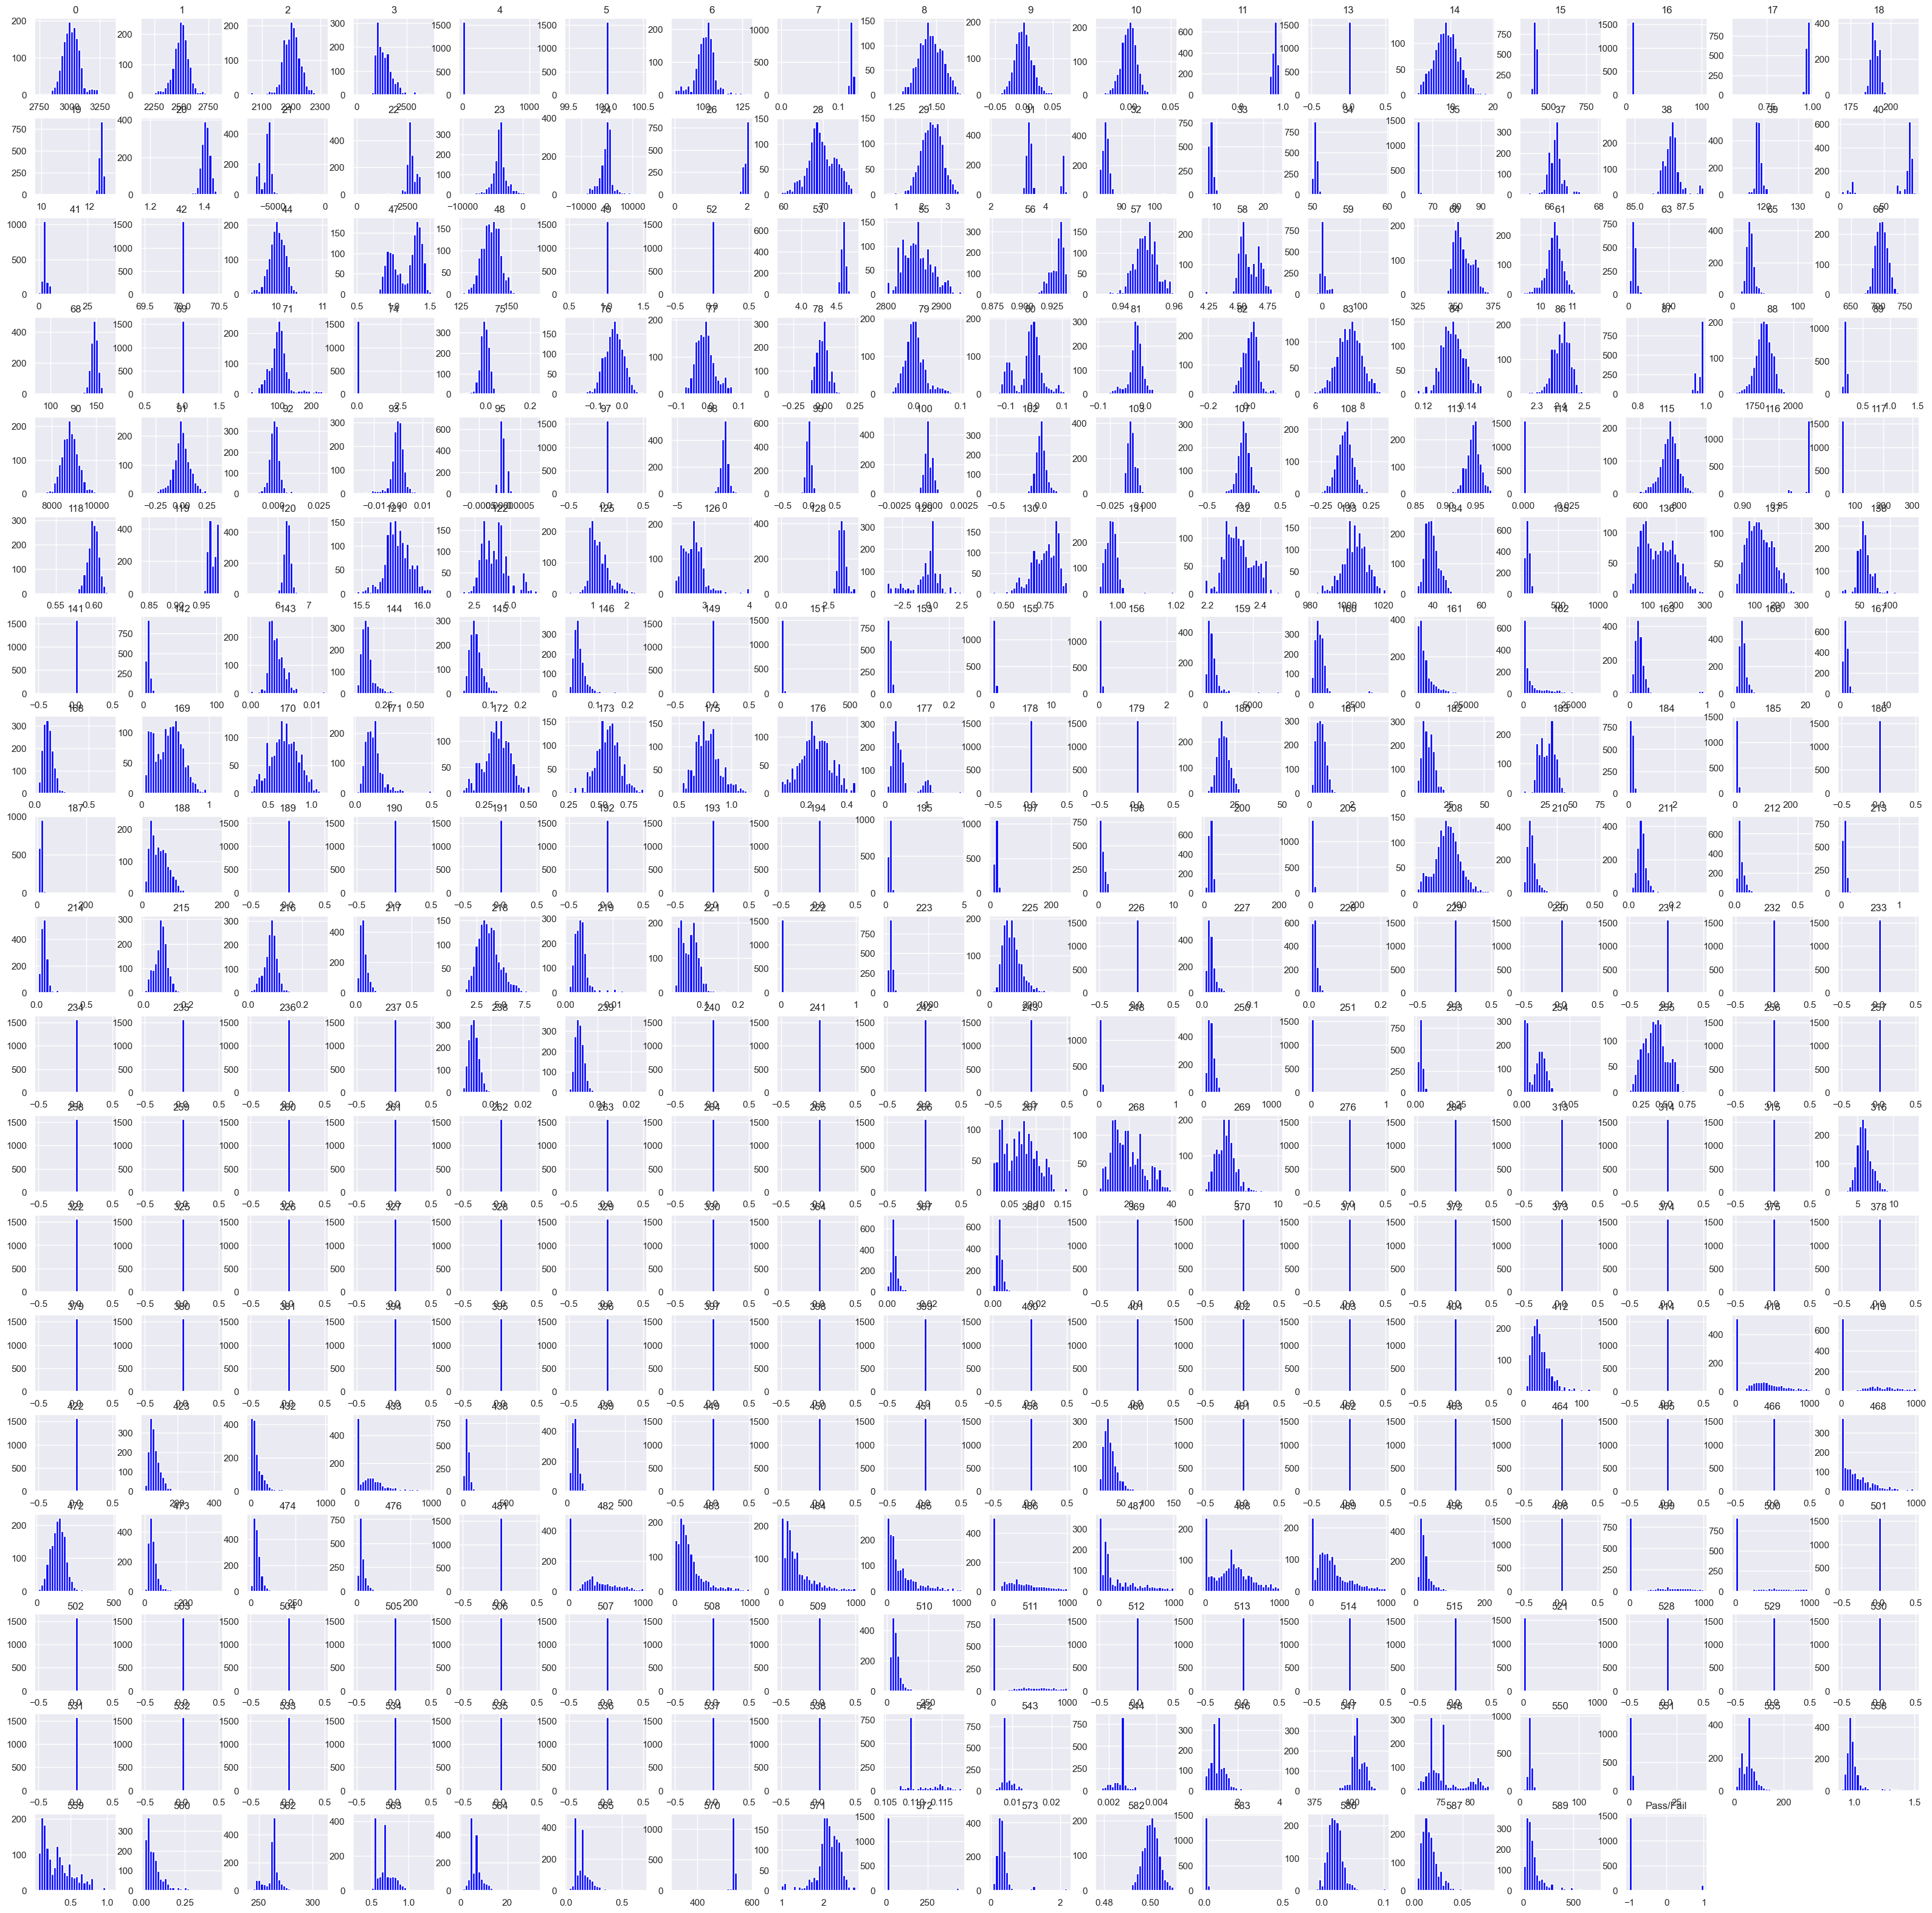

In [74]:
#3A : A. Perform a detailed univariate Analysis with appropriate detailed comments after each analysis

#plotting histogram to check for the frequency of values within a variable
signal_clean3.hist(bins = 30, figsize = (40, 40), color = 'blue')
plt.show()

From the above histogram, it is seen that the values from different sensors are not all normally distributed.

No clear pattern is observed. Some sensors have data that are skewed and uniform as well.

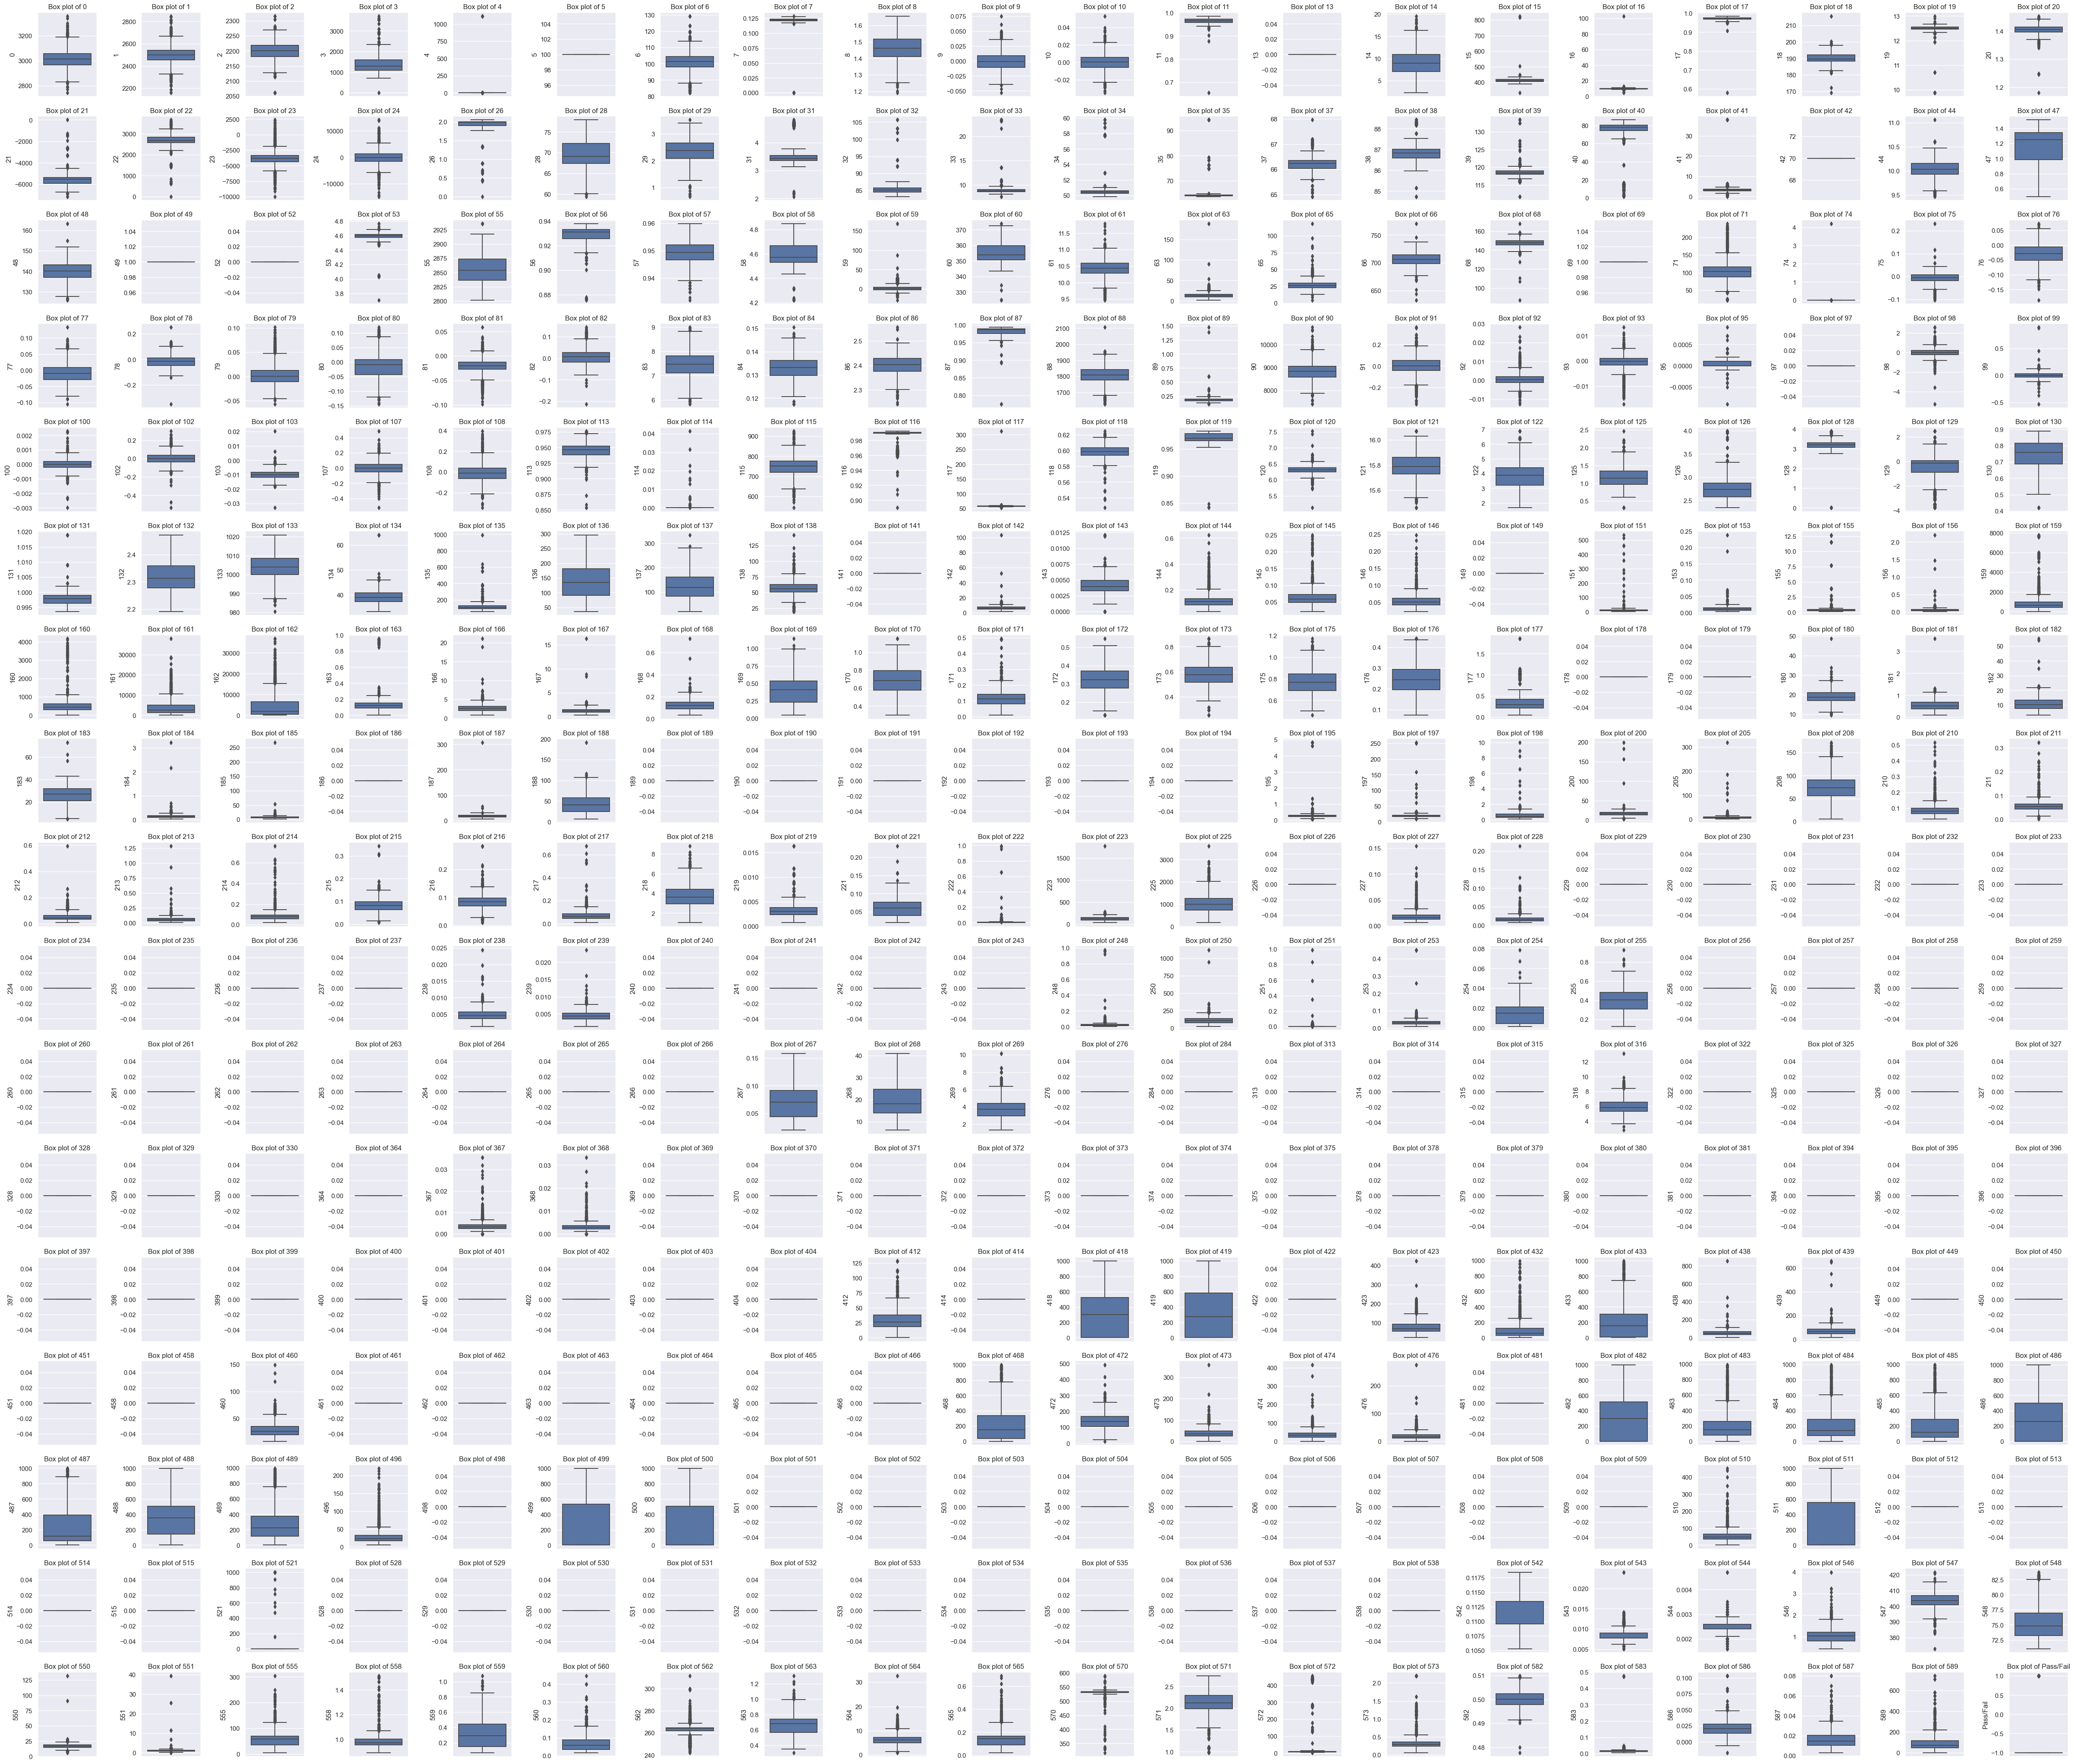

In [75]:
# Plot box plots for numeric features
plt.figure(figsize=(50, 50))
for i, column in enumerate(signal_clean3.columns, 1):
    plt.subplot(20, 20, i)
    sns.boxplot(y=signal_clean3[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

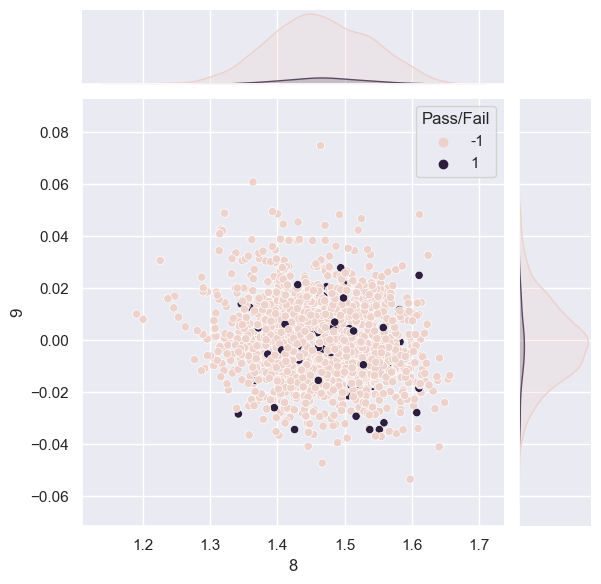

In [76]:
# 3B. Perform bivariate and multivariate analysis with appropriate detailed comments after each analysis.

# Bivariate Analysis
sns.jointplot(data = signal_clean3, x='8',y='9', hue = 'Pass/Fail');

The above plot indicates that the scale of different variables are different.

There is no pattern to clearly say that a particular sensor reading is pass or fail. Because of the size and randomness of the sensor data


### 4. Data pre-processing

In [79]:
#4A. Segregate predictors vs target attributes.

if 'Pass/Fail' in signal_clean3.columns:
    # Segregate predictors (independent variables) and target (dependent variable)
    X = signal_clean3.drop(columns=['Pass/Fail'])
    y = signal_clean3['Pass/Fail']
    
    # Verify the segregation
    print("Shape of predictors (X):", X.shape)
    print("Shape of target (y):", y.shape)
    print("Predictors (X) columns:", X.columns)
    print("Target (y) column name:", y.name)
else:
    print("The target column 'Pass/Fail' does not exist in the DataFrame.")


Shape of predictors (X): (1567, 339)
Shape of target (y): (1567,)
Predictors (X) columns: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '565', '570', '571', '572', '573', '582', '583', '586', '587', '589'],
      dtype='object', length=339)
Target (y) column name: Pass/Fail


Target distribution (%):
 Pass/Fail
-1    93.363114
 1     6.636886
Name: proportion, dtype: float64


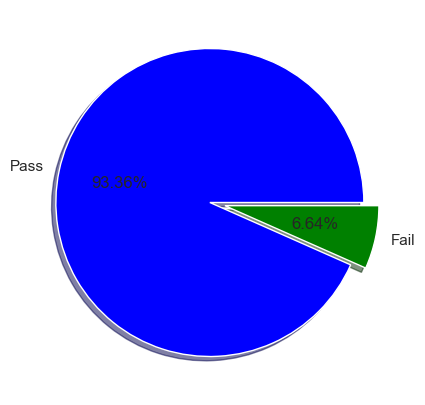

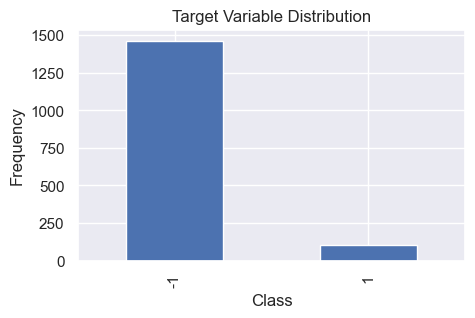

In [80]:
# 4B.Check for target balancing and fix it if found imbalanced.

# pie chart

labels = ['Pass', 'Fail']
size = signal_clean3['Pass/Fail'].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (5, 5)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)


# Check the distribution of the target variable
target_distribution = y.value_counts(normalize=True) * 100
print("Target distribution (%):\n", target_distribution)

# Plot the distribution
plt.figure(figsize=(5, 3))
y.value_counts().plot(kind='bar')
plt.title('Target Variable Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


In [81]:
# 4C Perform train-test split and standardise the data or vice versa if required.

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test =train_test_split(X,y, test_size=.30,random_state=105,stratify=y)
# gettiing the shapes
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)
print("shape of Y_train: ", Y_train.shape)
print("shape of Y_test: ", Y_test.shape)

shape of X_train:  (1096, 339)
shape of X_test:  (471, 339)
shape of Y_train:  (1096,)
shape of Y_test:  (471,)


In [93]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_train_res.shape))


After OverSampling, the shape of train_X: (2048, 339)
After OverSampling, the shape of train_y: (2048,)


In [98]:
# standardization

# Creating a standard scaler
scaler = StandardScaler()

# Perform standardization
normalized_x_train = scaler.fit_transform(X_train_res)
normalized_x_test = scaler.transform(X_test)

# Convert the standardized data back to DataFrame
normalized_x_train = pd.DataFrame(normalized_x_train)
normalized_x_test = pd.DataFrame(normalized_x_test)

# Verify the transformation
print(f"X_train shape: {normalized_x_train.shape}")
print(f"X_test shape: {normalized_x_test.shape}")

X_train shape: (2048, 339)
X_test shape: (471, 339)


In [99]:
#4D. Check if the train and test data have similar statistical characteristics when compared with original data.

# Convert arrays back to DataFrames for easier comparison
X_train_res_df = pd.DataFrame(X_train_res, columns=signal_clean3.drop(columns=['Pass/Fail']).columns)
X_train_df = pd.DataFrame(X_train, columns=signal_clean3.drop(columns=['Pass/Fail']).columns)
X_test_df = pd.DataFrame(X_test, columns=signal_clean3.drop(columns=['Pass/Fail']).columns)

# Function to display descriptive statistics
def display_statistics(original, train, test):
    print("Original Data Statistics:\n", original.describe())
    print("\nTraining Data Statistics:\n", train.describe())
    print("\nTest Data Statistics:\n", test.describe())

# Display statistics
display_statistics(X_train_res_df, X_train_df, X_test_df)


Original Data Statistics:
                  0            1            2            3            4  \
count  2048.000000  2048.000000  2048.000000  2048.000000  2048.000000   
mean   3012.053729  2496.780963  2199.668193  1364.666464     2.970125   
std      71.758406    68.911126    26.350242   364.565941    42.525064   
min    2787.490000  2158.750000  2060.660000   711.025800     0.681500   
25%    2963.154032  2457.640000  2181.188900  1107.250920     1.089781   
50%    3004.337903  2498.185000  2199.486607  1281.786200     1.320400   
75%    3053.002424  2534.718278  2215.388900  1552.668019     1.502212   
max    3282.870000  2810.120000  2304.211100  3619.739700  1114.536600   

            5            6            7            8            9  ...  \
count  2048.0  2048.000000  2048.000000  2048.000000  2048.000000  ...   
mean    100.0   101.451511     0.122162     1.471053    -0.002156  ...   
std       0.0     5.361402     0.005663     0.062755     0.013374  ...   
min     10

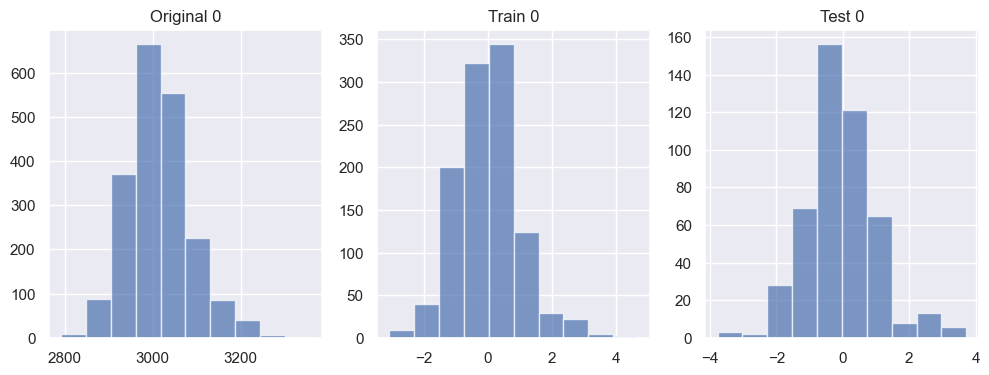

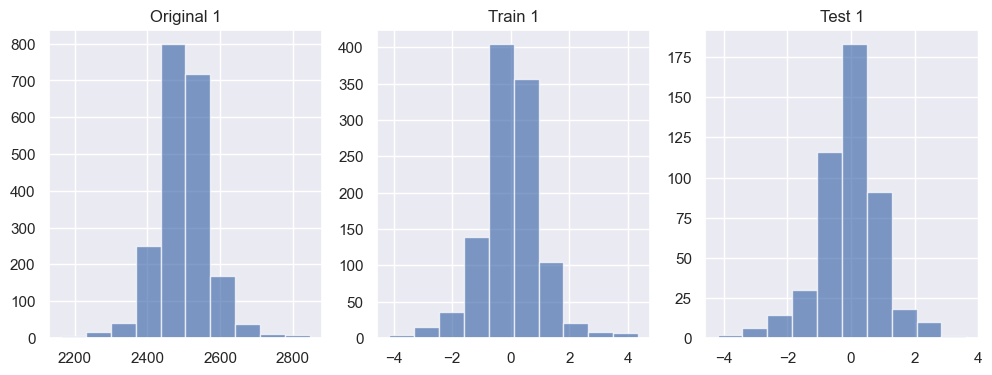

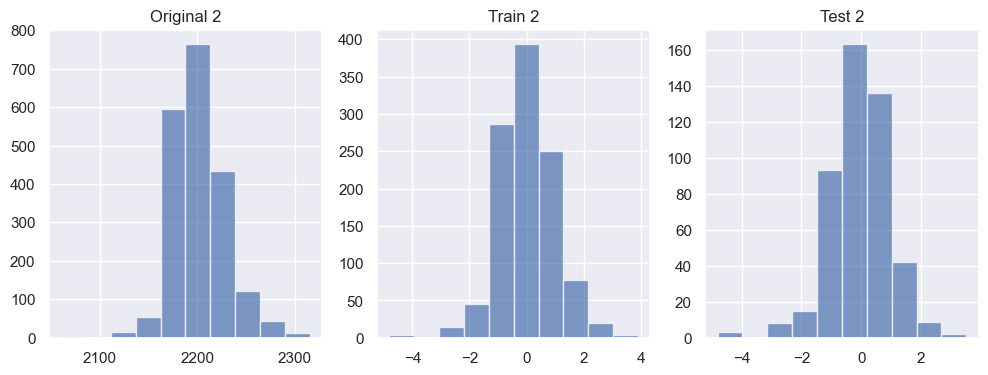

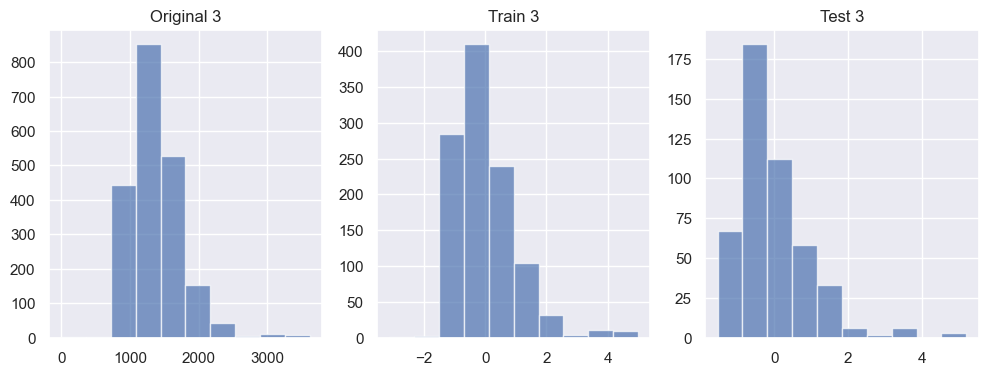

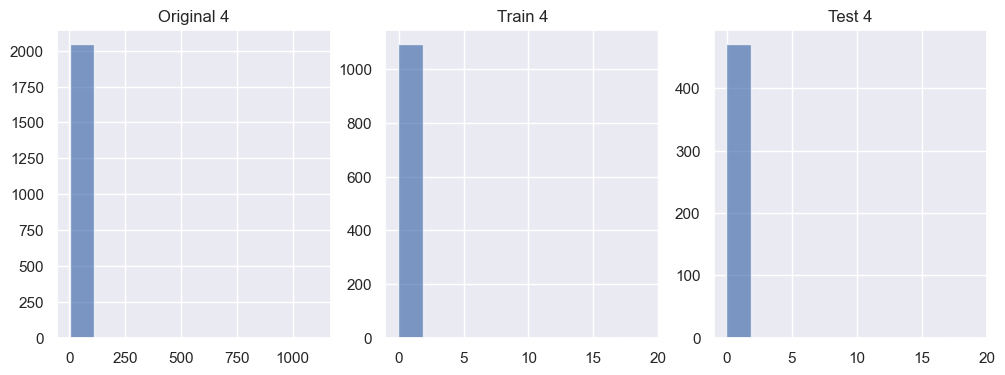

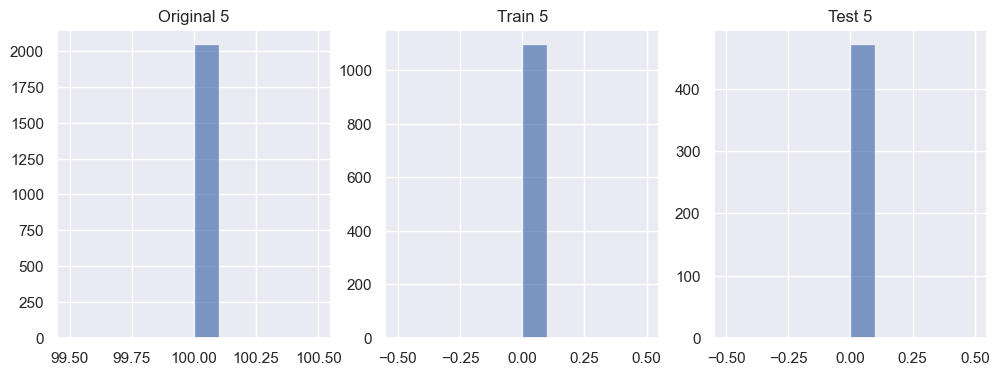

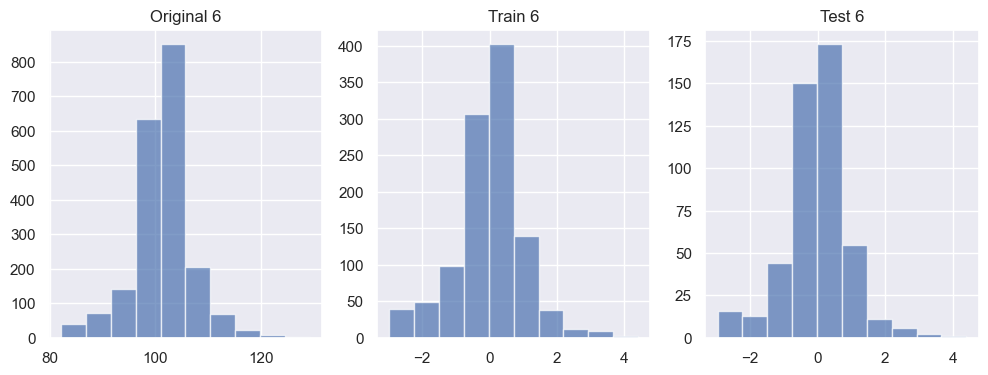

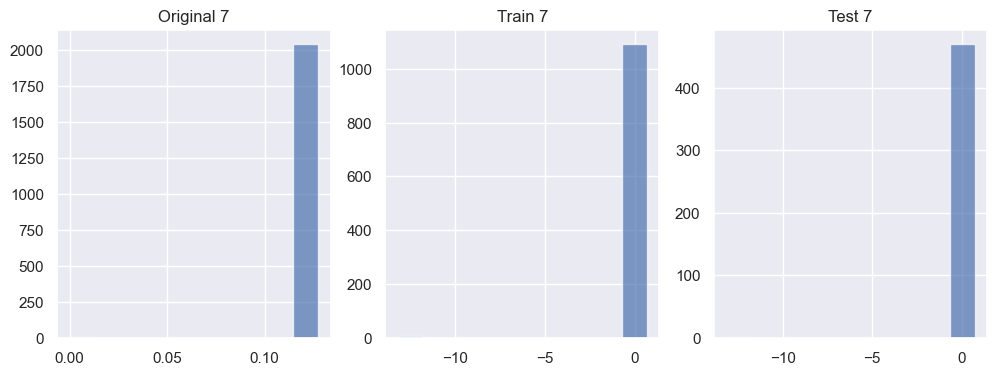

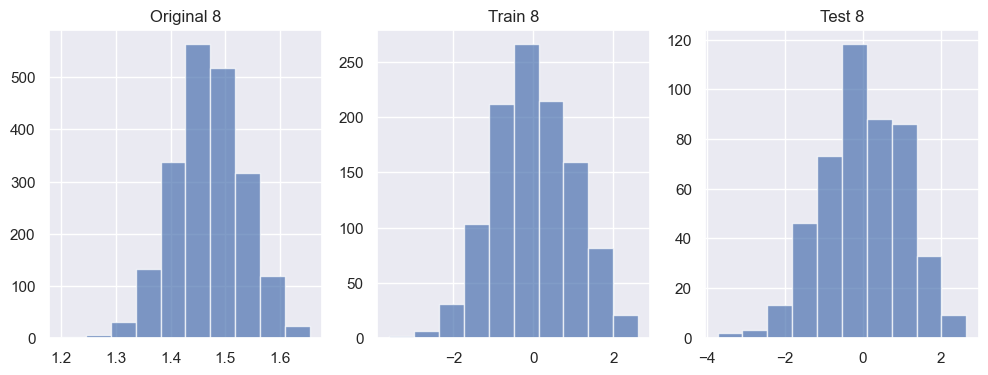

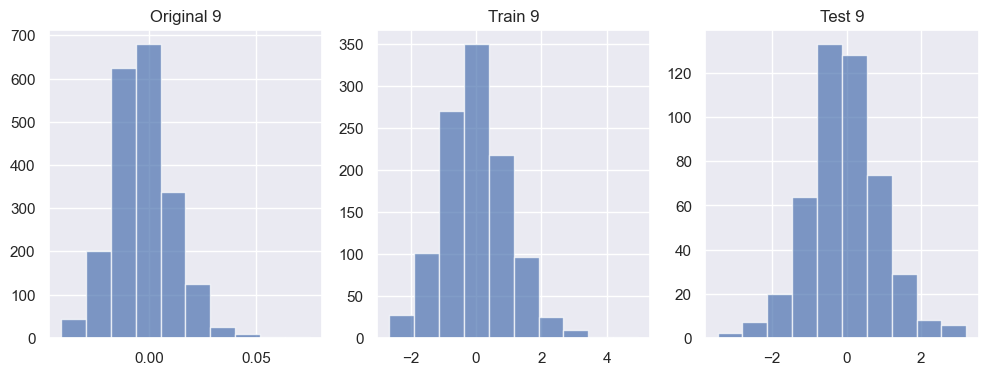

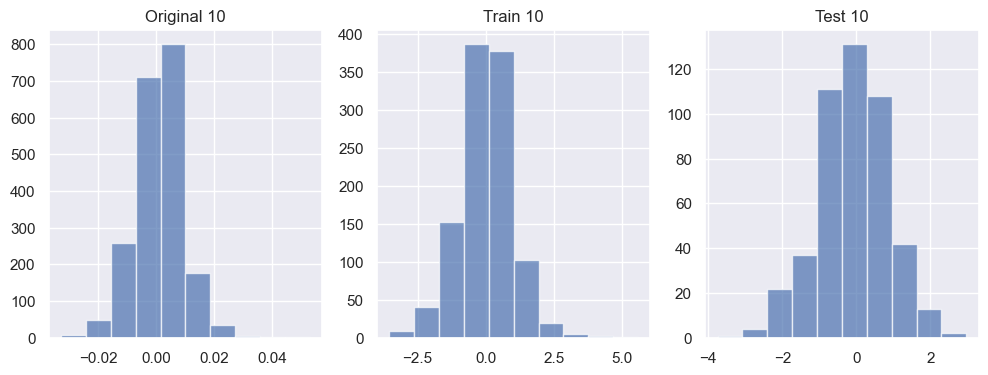

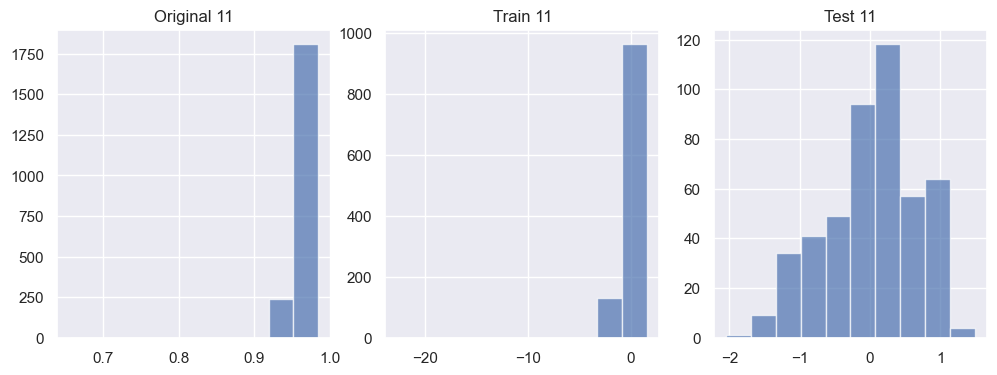

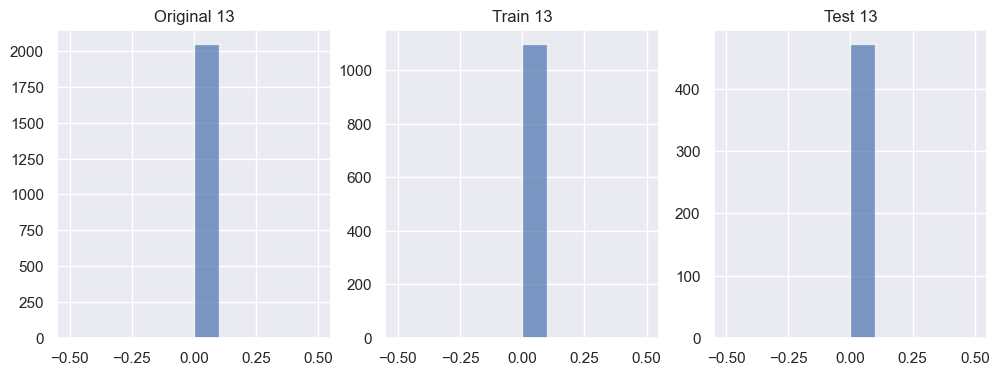

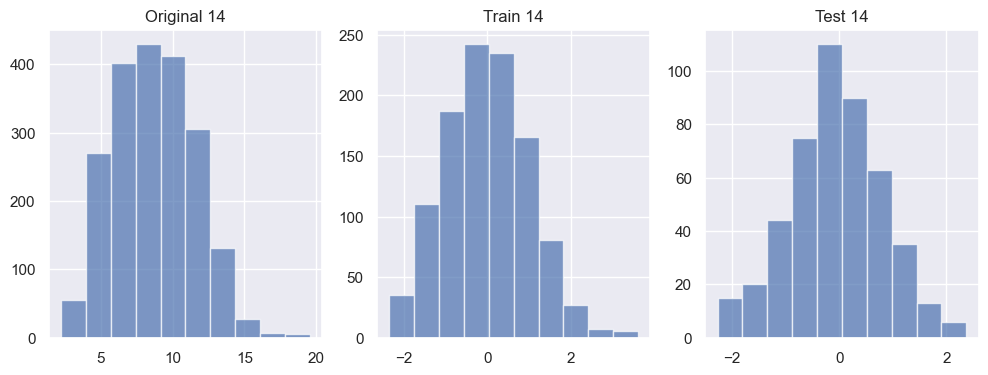

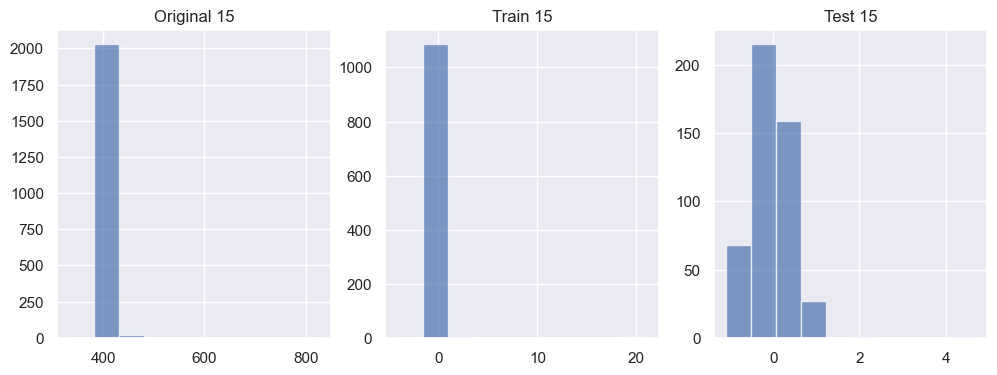

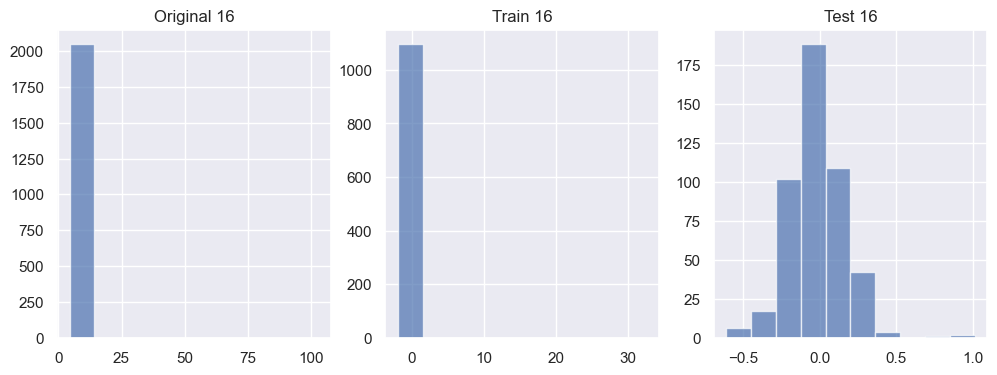

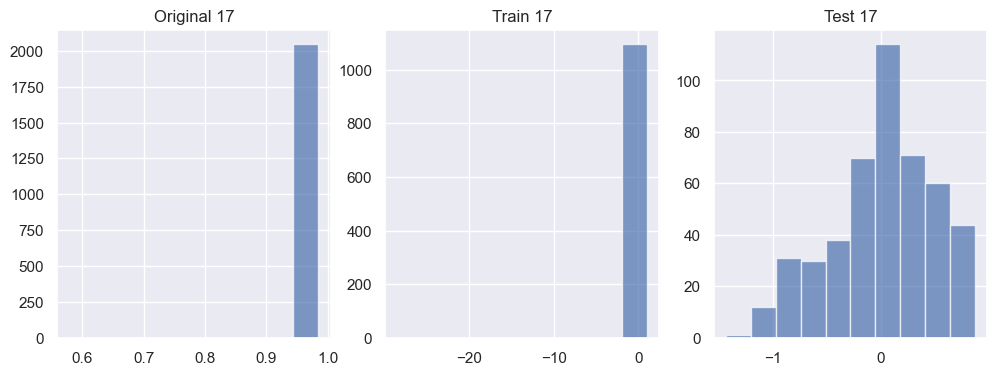

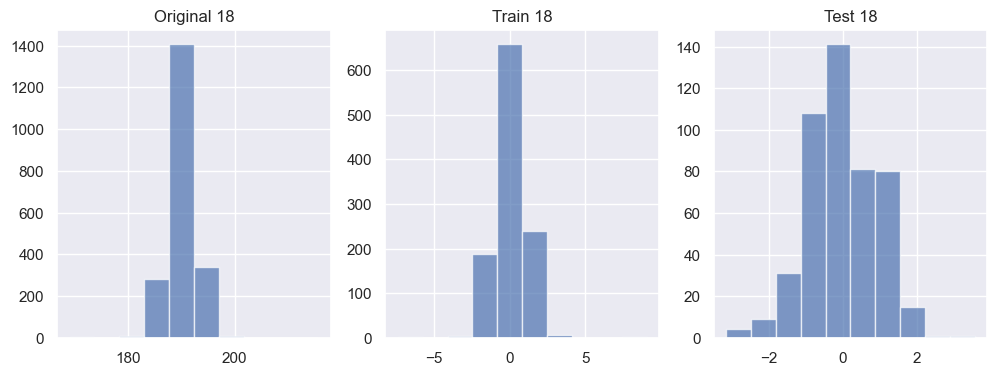

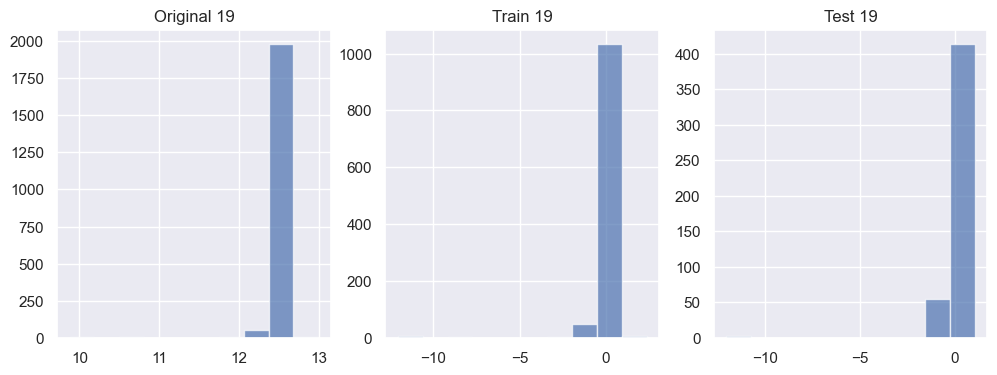

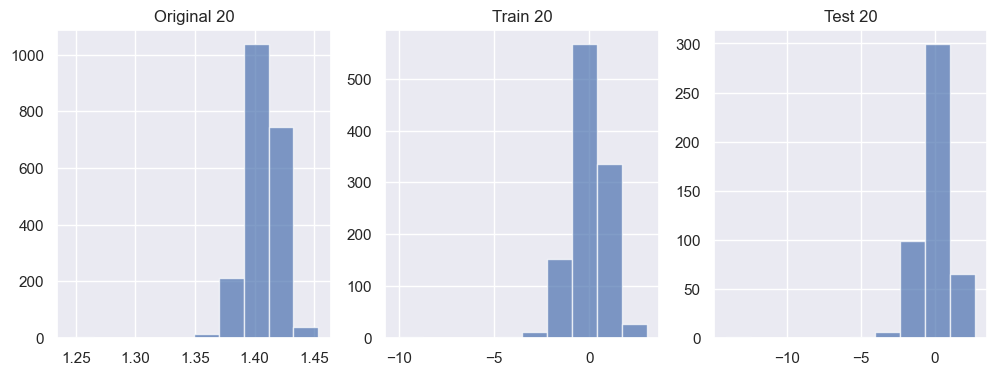

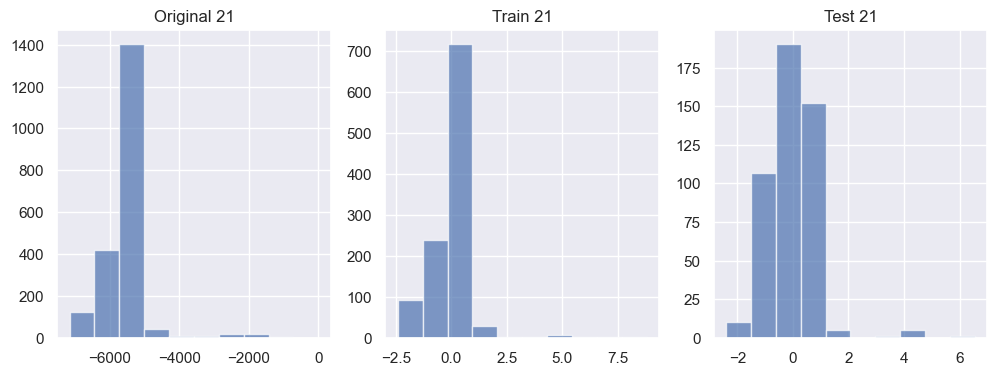

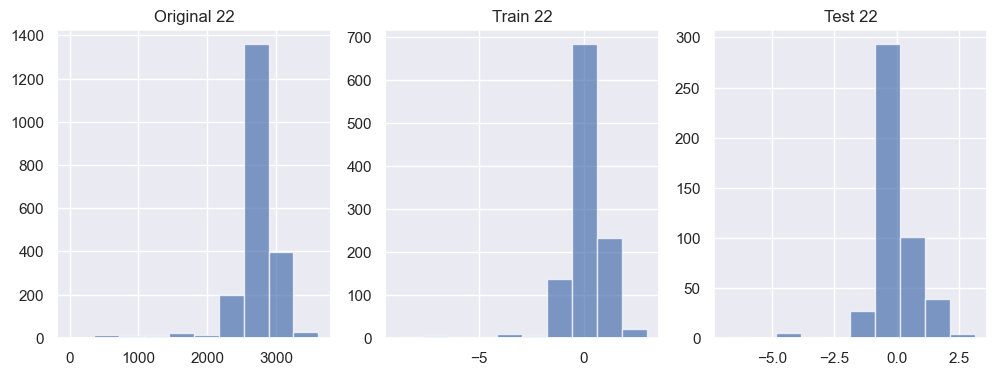

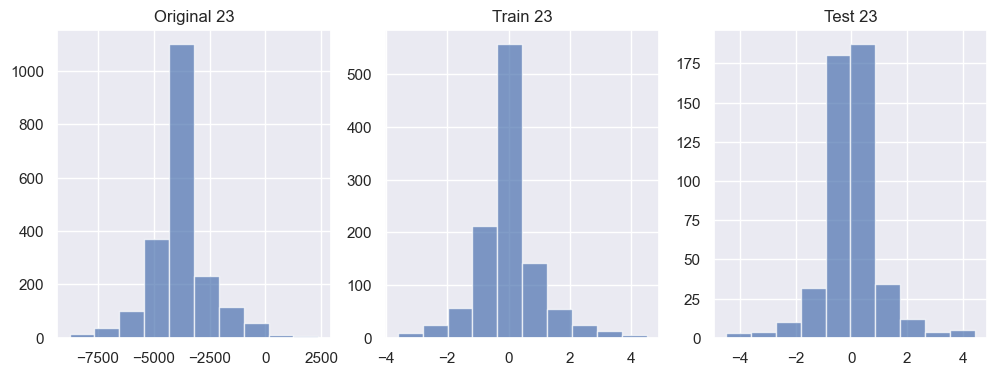

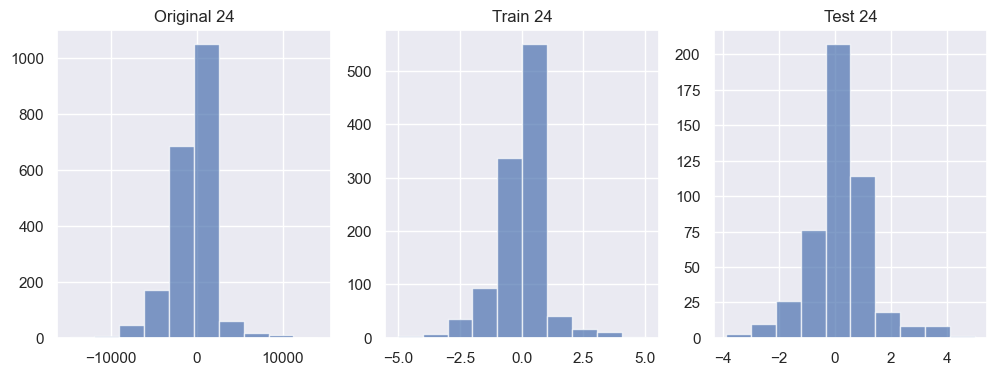

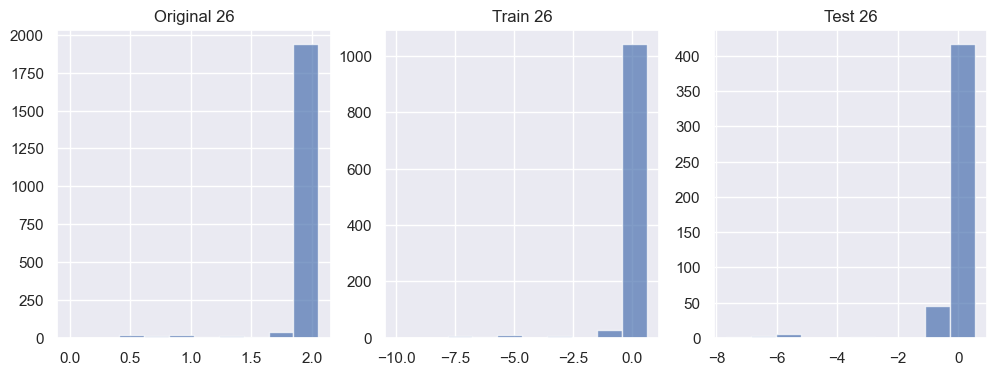

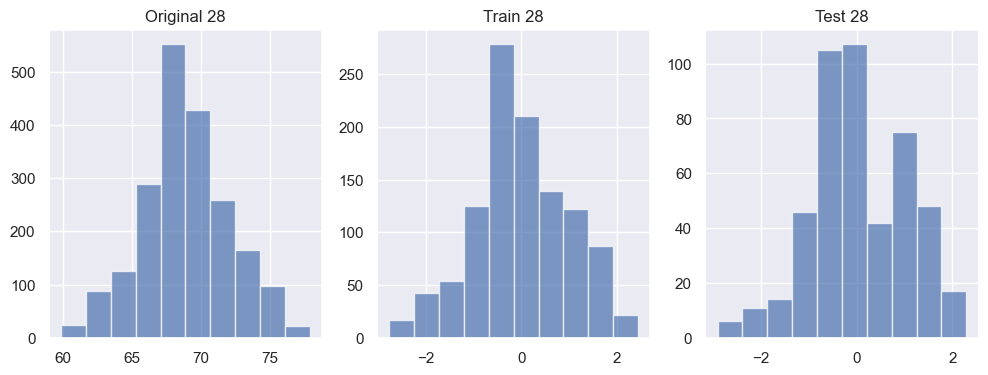

KeyboardInterrupt: 

In [85]:
# Plot histograms for visual comparison
def plot_histograms(original, train, test, features):
    for feature in features:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.hist(original[feature], bins=10, alpha=0.7, label='Original')
        plt.title(f'Original {feature}')
        
        plt.subplot(1, 3, 2)
        plt.hist(train[feature], bins=10, alpha=0.7, label='Train')
        plt.title(f'Train {feature}')
        
        plt.subplot(1, 3, 3)
        plt.hist(test[feature], bins=10, alpha=0.7, label='Test')
        plt.title(f'Test {feature}')
        
        plt.show()

# Call the function to plot histograms
plot_histograms(X_train_res_df, X_train_df, X_test_df, signal_clean3.drop(columns=['Pass/Fail']).columns)


In [87]:
# Class count for training data

print("Before UpSampling, counts of label Pass '-1': {}".format(sum(Y_train== -1)))
print("Before UpSampling, counts of label Fail '1': {} \n".format(sum(Y_train== 1)))

print("After UpSampling, counts of label Pass '-1': {}".format(sum(Y_train_res== -1)))
print("After UpSampling, counts of label Fail '1': {} \n".format(sum(Y_train_res== 1)))

Before UpSampling, counts of label Pass '-1': 1023
Before UpSampling, counts of label Fail '1': 73 

After UpSampling, counts of label Pass '-1': 1023
After UpSampling, counts of label Fail '1': 1023 



In [88]:
# Class count for test data
Y_test.value_counts()

Pass/Fail
-1    440
 1     31
Name: count, dtype: int64

### 5. Model training, testing and tuning:

In [100]:
# 5A. Use any Supervised Learning technique to train a model.

# calculate accuracy measures and confusion matrix
from sklearn import metrics

from sklearn.metrics import recall_score

# Fit the model on training data
logreg = LogisticRegression()

logreg.fit(normalized_x_train, y_train_res)
y_predict = logreg.predict(normalized_x_test)
model_score = logreg.score(normalized_x_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_predict))
print(metrics.classification_report(y_test, y_predict))

0.5796178343949044
[[253 186]
 [ 12  20]]
              precision    recall  f1-score   support

          -1       0.95      0.58      0.72       439
           1       0.10      0.62      0.17        32

    accuracy                           0.58       471
   macro avg       0.53      0.60      0.44       471
weighted avg       0.90      0.58      0.68       471



In [101]:
# Training Accuracy
print('Training Accuracy is: ',logreg.score(normalized_x_train, y_train_res)*100)

# Test Accuracy
print('Test Accuracy is: ',logreg.score(normalized_x_test, y_test)*100)

Training Accuracy is:  98.828125
Test Accuracy is:  57.961783439490446


In [103]:
# 5B Use cross validation techniques:

# Import libraries for KFold CV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Define number of folds
num_folds = 50

# Create KFolds object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)

# Store results of CV score
results = cross_val_score(logreg, normalized_x_train, y_train_res, cv=kfold)

# Print the results
print(f"Cross-validation scores: {results}")
print(f"Mean CV score: {results.mean()}")
print(f"Standard deviation of CV scores: {results.std()}")


Cross-validation scores: [0.87804878 0.97560976 0.95121951 1.         1.         0.90243902
 0.95121951 0.92682927 1.         0.92682927 0.90243902 1.
 1.         0.90243902 0.95121951 0.95121951 0.97560976 0.92682927
 0.92682927 0.95121951 0.95121951 0.95121951 0.87804878 0.92682927
 0.90243902 0.95121951 1.         0.97560976 0.92682927 0.85365854
 0.87804878 0.92682927 1.         0.97560976 0.95121951 1.
 0.87804878 0.97560976 0.97560976 0.97560976 0.92682927 0.97560976
 0.87804878 0.90243902 0.97560976 0.97560976 0.97560976 0.92682927
 0.875      0.925     ]
Mean CV score: 0.9438048780487804
Standard deviation of CV scores: 0.040710590407492135


In [104]:
# Leave One Out Cross-Validation
# Import library
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

loo = LeaveOneOut()

# Store LOOCV scores
scores = cross_val_score(logreg, normalized_x_train, y_train_res, cv=loo)

# Print the results
print(f"LOOCV scores: {scores}")
print(f"Mean LOOCV score: {scores.mean()}")
print(f"Standard deviation of LOOCV scores: {scores.std()}")


LOOCV scores: [1. 1. 1. ... 1. 1. 1.]
Mean LOOCV score: 0.9423828125
Standard deviation of LOOCV scores: 0.2330181263434024


In [105]:
# k-fold cross validation with stratification
k = 10
from sklearn.model_selection  import StratifiedKFold, cross_val_score

# Create StratifiedKFold object
stratified_kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)

# Store results of CV score
results = cross_val_score(logreg, normalized_x_train, y_train_res, cv=stratified_kfold)

# Print the results
print(f"Stratified K-Fold CV scores: {results}")
print(f"Mean Stratified K-Fold CV score: {results.mean()}")
print(f"Standard deviation of Stratified K-Fold CV scores: {results.std()}")

Stratified K-Fold CV scores: [0.93658537 0.93658537 0.96097561 0.94634146 0.93658537 0.94146341
 0.92682927 0.96097561 0.91666667 0.94607843]
Mean Stratified K-Fold CV score: 0.9409086561453849
Standard deviation of Stratified K-Fold CV scores: 0.013053316494924755


In [106]:
# Bootstrapping
# Number of iterations for bootstrapping
bootstrap_iteration = 10
accuracy = []

from sklearn.utils import resample
from sklearn.metrics import accuracy_score

for i in range(bootstrap_iteration):
    X_, y_ = resample(normalized_x_train, y_train_res)
    logreg.fit(X_, y_)
    y_pred = logreg.predict(normalized_x_test)
    
    acc = accuracy_score(y_pred, y_test)
    accuracy.append(acc)
    
# Print the accuracy results
print(f"Bootstrap accuracies: {accuracy}")
print(f"Mean bootstrap accuracy: {np.mean(accuracy)}")
print(f"Standard deviation of bootstrap accuracies: {np.std(accuracy)}")

Bootstrap accuracies: [0.6199575371549894, 0.6178343949044586, 0.5902335456475584, 0.5881104033970276, 0.5732484076433121, 0.5711252653927813, 0.5690021231422505, 0.6008492569002123, 0.5902335456475584, 0.6072186836518046]
Mean bootstrap accuracy: 0.5927813163481954
Standard deviation of bootstrap accuracies: 0.017579822967715028


* k-fold cross validation with stratification gives the best results.

* The standard deviation is the lowest.

In [107]:
# 5C Apply hyper-parameter tuning techniques to get the best accuracy:
# Suggestion: Use all possible hyper parameter combinations to extract the best accuracies.

# Define grid
grid={"penalty":['l1','l2','elasticnet','none'],
      "C" : np.logspace(-5,5,10),
      "class_weight":['balanced','none'],
      "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      "random_state": [1]}

# Apply GridSearchCV
from sklearn.model_selection import GridSearchCV
logreg=LogisticRegression()
grid_logreg=GridSearchCV(logreg,grid,cv=10)
grid_logreg.fit(normalized_x_train, y_train_res)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                         'class_weight': ['balanced', 'none'],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'random_state': [1],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [108]:

# Print the best parameters and the best score
print("tuned hpyerparameters :(best parameters) ", grid_logreg.best_params_)
print("Best cross-validation score:(accuracy) ", grid_logreg.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1e-05, 'class_weight': 'balanced', 'penalty': 'none', 'random_state': 1, 'solver': 'lbfgs'}
Best cross-validation score:(accuracy)  0.9462912482065995


In [109]:
# run randomized search
from sklearn.model_selection import RandomizedSearchCV

samples = 10  # number of random samples 
logreg_randomCV = RandomizedSearchCV(logreg, param_distributions=grid, n_iter=samples, random_state=1) #default cv = 3

logreg_randomCV.fit(normalized_x_train, y_train_res)

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions={'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                        'class_weight': ['balanced', 'none'],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'random_state': [1],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=1)

In [110]:
print("tuned hpyerparameters :(best parameters) ",logreg_randomCV.best_params_)
print("accuracy :",logreg_randomCV.best_score_*100)

tuned hpyerparameters :(best parameters)  {'solver': 'sag', 'random_state': 1, 'penalty': 'l2', 'class_weight': 'balanced', 'C': 7742.636826811277}
accuracy : 92.48041028087542


In [111]:
# 5D Use any other technique/method which can enhance the model performance. [4 Marks]
normalized_x_train.shape

(2048, 339)

In [112]:
from sklearn.decomposition import PCA
# Initialize PCA object
pca = PCA(134)
# Fit the PCA object with the train data
pca.fit(normalized_x_train) 

PCA(n_components=134)

In [113]:
# Covariance matrix
cov_matrix = np.cov(normalized_x_train.T) # the relevanat covariance matrix
print('Covariance Matrix \n%s', cov_matrix)

#generating the eigen values and the eigen vectors
e_vals, e_vecs = np.linalg.eig(cov_matrix)
print('Eigenvectors \n%s' %e_vecs)
print('\nEigenvalues \n%s' %e_vals)

# the "cumulative variance explained" analysis 
tot = sum(e_vals)
var_exp = [( i /tot ) * 100 for i in sorted(e_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Covariance Matrix 
%s [[ 1.00048852e+00 -1.97499688e-01  1.00419601e-01 ...  4.36827322e-03
  -2.08881287e-02  1.87786284e-02]
 [-1.97499688e-01  1.00048852e+00  1.86691688e-02 ...  2.99753304e-02
   7.58552223e-02  5.38291964e-02]
 [ 1.00419601e-01  1.86691688e-02  1.00048852e+00 ... -5.13119546e-04
  -4.77157328e-02 -7.17689553e-02]
 ...
 [ 4.36827322e-03  2.99753304e-02 -5.13119546e-04 ...  1.00048852e+00
   2.16869138e-01 -4.84516118e-01]
 [-2.08881287e-02  7.58552223e-02 -4.77157328e-02 ...  2.16869138e-01
   1.00048852e+00  3.87973754e-01]
 [ 1.87786284e-02  5.38291964e-02 -7.17689553e-02 ... -4.84516118e-01
   3.87973754e-01  1.00048852e+00]]
Eigenvectors 
[[-0.06578746 -0.03044787  0.01363609 ...  0.          0.
   0.        ]
 [ 0.03925059  0.04687096 -0.00190077 ...  0.          0.
   0.        ]
 [ 0.03260797 -0.08472407 -0.01893522 ...  0.          0.
   0.        ]
 ...
 [-0.05450883  0.03433112  0.04376115 ...  0.          0.
   0.        ]
 [ 0.04173965  0.02187587 -0.05

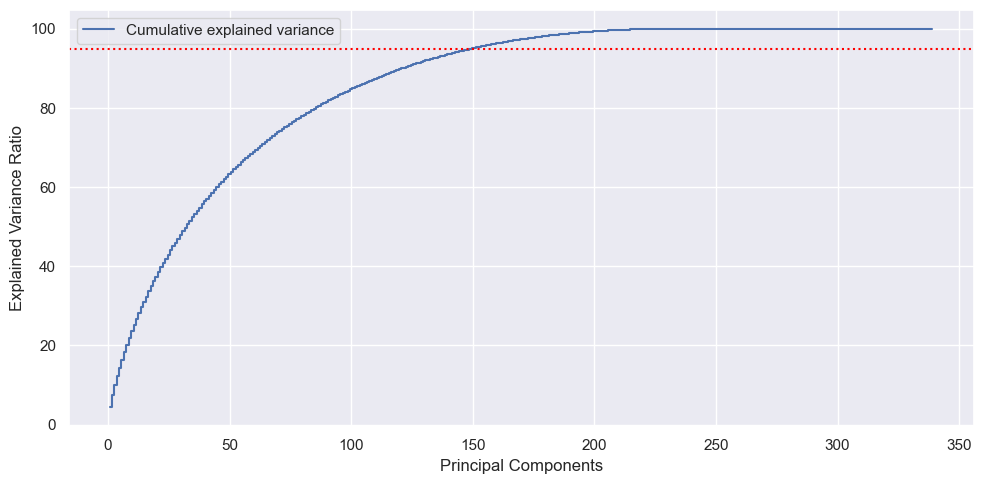

In [114]:
# Plotting the variance expalained by the principal components and the cumulative variance explained.
plt.figure(figsize=(10 , 5))
plt.step(range(1, e_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')

# Plot horizontal line
# matplotlib.pyplot.axhline(y, xmin, xmax, color, label)

plt.axhline(95, 0, 20, color='red', linestyle='dotted')

plt.tight_layout()
plt.show()

With approximately 150 variables we can explain over 95% of the variation in the original data!

In [115]:
pca_new = PCA(n_components=85)
pca_new.fit(normalized_x_train)

PCA(n_components=85)

In [116]:
# Check out the new components
comp1 = pd.DataFrame(pca_new.components_,columns=list(normalized_x_train))
comp1.head()

0         1         2         3         4             5         6    \
0 -0.065787  0.039250  0.032608 -0.048793 -0.009713  3.174706e-19  0.051506   
1 -0.030447  0.046870 -0.084724 -0.054723  0.018033  7.431582e-18  0.002486   
2 -0.013634  0.001901  0.018933 -0.000172 -0.000558  2.899357e-17  0.042680   
3 -0.035569 -0.014098 -0.098442 -0.116330 -0.017577  2.259524e-17  0.132070   
4 -0.044817 -0.077275 -0.051789 -0.013382 -0.004923 -3.260828e-17  0.002314   

        7         8         9    ...       329       330       331       332  \
0 -0.010275  0.043954 -0.026464  ... -0.013299  0.008596  0.093004 -0.024558   
1  0.009340  0.031784 -0.007770  ... -0.011495  0.017082 -0.034560 -0.001288   
2  0.003426 -0.019293 -0.031056  ...  0.058760  0.035617 -0.009919 -0.021009   
3  0.021401  0.021380 -0.009866  ...  0.013746 -0.004169 -0.065999  0.000358   
4  0.006031  0.043754 -0.007812  ... -0.004334 -0.006666  0.141998  0.044311   

        333       334       335       336       337       338  
0 -0.009284  0.003858  0.012252 -0.054509  0.041740  0.053266  
1  0.010140  0.058322 -0.010862  0.034331  0.021877 -0.005597  
2 -0.049848 -0.050005  0.041509 -0.043762  0.050708  0.091536  
3 -0.027759  0.052333  0.002952 -0.014629  0.028423  0.029802  
4  0.119091  0.002772  0.006667 -0.025387 -0.012767  0.023840  

[5 rows x 339 columns]

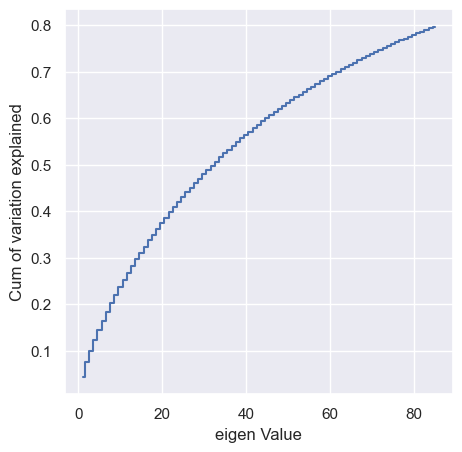

In [117]:
# Plot cumulative variances vs eigen values
plt.step(list(range(1,86)),np.cumsum(pca_new.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [118]:
# Create training dataset with the trained PCA model
pca_normalized_x_train = pca_new.transform(normalized_x_train)
pca_normalized_x_train

array([[ 0.79430816, -3.03116961, -0.18990473, ...,  0.97402446,
        -0.78160949, -0.58741588],
       [ 1.68120763, -1.61089021,  2.12734946, ..., -2.05330273,
         0.15726419,  0.59806099],
       [ 3.21897081, -0.62812351,  2.78145006, ..., -1.50930542,
         0.13250247, -0.54977306],
       ...,
       [ 1.26423809, -3.10884075,  2.02177641, ...,  0.44554849,
        -0.8886704 , -0.26549521],
       [ 3.27864065, -1.27001441,  1.81916477, ..., -0.17133298,
        -0.3924506 ,  0.13965084],
       [ 0.18471918, -0.60692871, -1.84078361, ..., -0.23856993,
         0.0304366 , -0.29105468]])

In [119]:
# Create test dataset with the trained PCA model
pca_normalized_x_test = pca_new.transform(normalized_x_test)
pca_normalized_x_test

array([[ 4.72768584e+02,  2.23965770e+00,  2.54221595e+02, ...,
         5.83388759e+02,  6.32612511e+02, -3.33191698e+02],
       [-1.03033465e+03,  1.62181052e+02,  1.55396850e+02, ...,
        -9.91097324e+02, -1.62538965e+03,  6.31926159e+02],
       [-3.41352084e+02,  2.83647216e+01, -4.17916221e+02, ...,
        -1.12844438e+03, -5.06272536e+02,  4.59950706e+02],
       ...,
       [ 1.08490971e+03, -1.07773340e+02,  4.01721559e+02, ...,
         2.68764219e+03,  1.65356322e+03, -1.78344513e+03],
       [ 4.92851669e+02,  1.34171714e+02,  9.94154670e+01, ...,
         9.02398404e+02,  4.25425150e+02, -2.97502784e+02],
       [ 3.97872552e+02, -9.54012683e+00,  8.34067418e+01, ...,
         7.06571456e+02,  5.19463799e+02, -2.73142954e+02]])

In [120]:
# 5E Display and explain the classification report in detail.

# Choose the best parameters from GridSearchCV
lr = LogisticRegression(C=7742.636826811277, class_weight='balanced', 
                        penalty='l2', random_state=1, solver='newton-cg')

lr.fit(pca_normalized_x_train, y_train_res)

LogisticRegression(C=7742.636826811277, class_weight='balanced', random_state=1,
                   solver='newton-cg')

In [121]:
# print the model's coefficients or other details
print("Model coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

Model coefficients: [[ 0.28844501  0.19221634  0.15545533  0.28182519 -0.18148827  0.33479673
  -0.48172898 -0.50969316  0.51331851  0.47445936  0.40574993 -0.2514906
   0.06601252 -0.07402611 -0.16142969 -0.54243766  0.60510003 -0.06070588
  -0.25314986 -0.04022377 -0.26915565 -0.27198195 -0.52355672  0.23774195
  -0.19690703 -0.02228079  0.24609968  0.29186889 -0.07368956 -0.1846548
  -0.25943408  0.47671115 -0.31741219 -0.17622677  0.2928856  -0.15257305
  -0.26435549 -0.07694965  0.10325895 -0.41566728 -0.02021347 -0.15394871
  -0.4414701  -0.07440918  0.1534717  -0.078579   -0.09519733 -0.14782252
   0.43294857 -0.44177612  0.32754369  0.18519848  0.10456887 -0.40223434
  -0.0879786  -0.348909   -0.77364551  0.00983034 -0.84141425  0.0674016
   0.29101701  0.18602972 -0.36722834 -0.62754304 -0.49712252 -0.26622204
   0.1927648  -0.38683102  0.13300375 -0.46185959  0.15675938 -0.04971725
   0.13662912  0.23777945 -0.59651022  0.51545239 -0.2091611  -0.21421644
   0.22843062  0.5670

In [122]:
# Cross Validation
stratified_kfold = StratifiedKFold(n_splits = 10)
results = cross_val_score(lr, pca_normalized_x_train, y_train_res, cv = stratified_kfold)
print('Accuracy Score')
print('Avearge: ', results.mean())
print('Standard deviation: ', results.std())

Accuracy Score
Avearge:  0.8847680535628886
Standard deviation:  0.01867987924169465


In [123]:
# Training Accuracy
lr_train_accu = lr.score(pca_normalized_x_train, y_train_res)
print('Training Accuracy for Logistic Regression Model is: ',lr_train_accu*100)

# Test Accuracy
lr_test_accu = lr.score(pca_normalized_x_test, y_test)
print('Test Accuracy for Logistic Regression Model is: ',lr_test_accu*100)

Training Accuracy for Logistic Regression Model is:  89.599609375
Test Accuracy for Logistic Regression Model is:  61.3588110403397


In [124]:
y_predict_lr = lr.predict(pca_normalized_x_test)
#print(metrics.confusion_matrix(y_test, y_predict))
print(metrics.classification_report(y_test, y_predict_lr))

              precision    recall  f1-score   support

          -1       0.95      0.62      0.75       439
           1       0.09      0.53      0.16        32

    accuracy                           0.61       471
   macro avg       0.52      0.58      0.45       471
weighted avg       0.89      0.61      0.71       471



*The classes are being predicted with 61% accuracy.

*95% of -1 class were predicted correctly as precision is 0.95.

*9% of 1 class were predicted correctly as precision is 0.09.

*62% of -1 class and 53% of 1 class were correctly identified, as given by recall.

*75% of -1 class and 16% of 1 class predictions were identified correctly, as given by the f1-score.

In [129]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# Calculate confusion matrix elements
tn, fp, fn, tp = confusion_matrix(y_test, y_predict_lr).ravel()

# Calculate evaluation metrics
lr_recall = round(tp / (tp + fn), 3)      # Recall
lr_precision = round(tp / (tp + fp), 3)   # Precision
lr_specificity = round(tn / (tn + fp), 3) # Specificity
lr_type_1_error = fp                      # False Positives
lr_type_2_error = fn                      # False Negatives
lr_f1_score = round(f1_score(y_test, y_predict_lr), 3)  # F1 Score

# Calculate accuracy
lr_train_accu = round(lr.score(pca_normalized_x_train, y_train_res), 3)
lr_test_accu = round(accuracy_score(y_test, y_predict_lr), 3)

# Print the results
print(f"Train Accuracy: {lr_train_accu}")
print(f"Test Accuracy: {lr_test_accu}")
print(f"Recall: {lr_recall}")
print(f"Precision: {lr_precision}")
print(f"Specificity: {lr_specificity}")
print(f"Type 1 Error (False Positives): {lr_type_1_error}")
print(f"Type 2 Error (False Negatives): {lr_type_2_error}")
print(f"F1 Score: {lr_f1_score}")



Train Accuracy: 0.896
Test Accuracy: 0.614
Recall: 0.531
Precision: 0.092
Specificity: 0.62
Type 1 Error (False Positives): 167
Type 2 Error (False Negatives): 15
F1 Score: 0.157


In [135]:
# Create a DataFrame with the evaluation metrics
final_result = pd.DataFrame({'Model' : ['Logistic Regression'], 
                             'Training Accuracy' : [lr_train_accu], 
                             'Test Accuracy' : [lr_test_accu],
                             'Type 1 Error' : [lr_type_1_error],
                             'Type 2 Error' :  [lr_type_2_error],
                             'F1-Score':[lr_f1_score],})

# Display the DataFrame
print(final_result)


                 Model  Training Accuracy  Test Accuracy  Type 1 Error  \
0  Logistic Regression              0.896          0.614           167   

   Type 2 Error  F1-Score  
0            15     0.157  


In [136]:
#5F. Apply the above steps for all possible models that you have learnt so far.

# Gaussian Naive Bayes Model for Classification

# Call library
from sklearn.naive_bayes import GaussianNB

# Define Model
gnb = GaussianNB()

# Fit the model
gnb.fit(pca_normalized_x_train, y_train_res)

GaussianNB()

In [137]:
# Cross Validation
stratified_kfold = StratifiedKFold(n_splits = 10)
results = cross_val_score(gnb, pca_normalized_x_train, y_train_res, cv = stratified_kfold)
print('Accuracy Score')
print('Avearge: ', results.mean())
print('Standard deviation: ', results.std())

Accuracy Score
Avearge:  0.8960186513629843
Standard deviation:  0.03360414268415522


In [138]:
# Make predictions
y_predict_gnb = gnb.predict(pca_normalized_x_test)

# Training Accuracy
gnb_train_accu = gnb.score(pca_normalized_x_train, y_train_res)

# Test Accuracy
gnb_test_accu = gnb.score(pca_normalized_x_test, y_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict_gnb).ravel()
gnb_recall = round(tp/(tp+fn), 3)   # Recall
gnb_precision = round(tp/(tp+fp), 3)  # Precision
gnb_specificity =round(tn/(tn+fp),3)    # Specificity
gnb_type_1_error = fp # False Positives
gnb_type_2_error = fn # False Negatives
gnb_f1_score = f1_score(y_test,y_predict_gnb) # F1 Score

# Create DataFrame
final_result_gnb = pd.DataFrame({
    'Model': ['Gaussian Naive Bayes'],
    'Training Accuracy': [gnb_train_accu],
    'Test Accuracy': [gnb_test_accu],
    'Recall': [gnb_recall],
    'Precision': [gnb_precision],
    'Specificity': [gnb_specificity],
    'Type 1 Error': [gnb_type_1_error],
    'Type 2 Error': [gnb_type_2_error],
    'F1-Score': [gnb_f1_score],
})

# Display the DataFrame
print(final_result_gnb)

                  Model  Training Accuracy  Test Accuracy  Recall  Precision  \
0  Gaussian Naive Bayes           0.901367       0.932059     0.0        NaN   

   Specificity  Type 1 Error  Type 2 Error  F1-Score  
0          1.0             0            32       0.0  


In [139]:
print(metrics.classification_report(y_test, y_predict_gnb))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



In [140]:
final_result.loc[1] = ['Gaussian Naive Bayes', gnb_train_accu,gnb_test_accu,
                       gnb_type_1_error,gnb_type_2_error,gnb_f1_score]
final_result

Model  Training Accuracy  Test Accuracy  Type 1 Error  \
0   Logistic Regression           0.896000       0.614000           167   
1  Gaussian Naive Bayes           0.901367       0.932059             0   

   Type 2 Error  F1-Score  
0            15     0.157  
1            32     0.000

In [145]:
# K Nearest Neighbour Model

from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Define Model
knn = KNeighborsClassifier()

# Define grid
grid = {
    "n_neighbors": list(range(1, 11)),
    "weights": ['uniform', 'distance'],
    "algorithm": ['ball_tree', 'kd_tree', 'brute'],
    "leaf_size": list(range(1, 50, 5)),
    "metric": ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

# Define RandomizedSearchCV
knn_randomCV = RandomizedSearchCV(knn, param_distributions=grid, random_state=1, refit=True, cv=10)

# Fit the model
knn_randomCV.fit(pca_normalized_x_train, y_train_res)


RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'leaf_size': [1, 6, 11, 16, 21, 26, 31,
                                                      36, 41, 46],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev', 'minkowski'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10],
                                        'weights': ['uniform', 'distance']},
                   random_state=1)

In [146]:
print("tuned hpyerparameters :(best parameters) ",knn_randomCV.best_params_)
print("accuracy :",knn_randomCV.best_score_*100)

tuned hpyerparameters :(best parameters)  {'weights': 'uniform', 'n_neighbors': 2, 'metric': 'euclidean', 'leaf_size': 26, 'algorithm': 'kd_tree'}
accuracy : 93.75035868005739


In [147]:
# Make predictions
y_predict_knn = knn_randomCV.predict(pca_normalized_x_test)

# Training Accuracy
knn_train_accu = knn_randomCV.score(pca_normalized_x_train, y_train_res)

# Test Accuracy
knn_test_accu = knn_randomCV.score(pca_normalized_x_test, y_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict_knn).ravel()
knn_recall = round(tp/(tp+fn), 3)   # Recall
knn_precision = round(tp/(tp+fp), 3)  # Precision
knn_specificity =round(tn/(tn+fp),3)    # Specificity
knn_type_1_error = fp # False Positives
knn_type_2_error = fn # False Negatives
knn_f1_score = f1_score(y_test,y_predict_knn) # F1 Score

print(metrics.classification_report(y_test, y_predict_knn))

              precision    recall  f1-score   support

          -1       0.93      0.65      0.77       439
           1       0.07      0.38      0.12        32

    accuracy                           0.63       471
   macro avg       0.50      0.51      0.44       471
weighted avg       0.88      0.63      0.72       471



In [148]:
final_result.loc[2] = ['K Nearest Neighbours', knn_train_accu,knn_test_accu,
                       knn_type_1_error,knn_type_2_error,knn_f1_score]
final_result

Model  Training Accuracy  Test Accuracy  Type 1 Error  \
0   Logistic Regression           0.896000       0.614000           167   
1  Gaussian Naive Bayes           0.901367       0.932059             0   
2  K Nearest Neighbours           1.000000       0.630573           154   

   Type 2 Error  F1-Score  
0            15  0.157000  
1            32  0.000000  
2            20  0.121212

In [149]:
# SVC Model
# Call library
from sklearn.svm import SVC

# Define Model
svc = SVC()

# Define grid
grid={'C': [0.1, 1, 10],
      'gamma': [1, 0.1, 0.01],
      'kernel': ['linear', 'rbf', 'sigmoid'],
      'random_state':[1]
      }

svc_randomCV = RandomizedSearchCV(svc, param_distributions=grid, random_state=1, refit=True, cv=10)

svc_randomCV.fit(pca_normalized_x_train, y_train_res)

RandomizedSearchCV(cv=10, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': [1, 0.1, 0.01],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'random_state': [1]},
                   random_state=1)

In [150]:
print("tuned hpyerparameters :(best parameters) ",svc_randomCV.best_params_)
print("accuracy :",svc_randomCV.best_score_*100)

tuned hpyerparameters :(best parameters)  {'random_state': 1, 'kernel': 'linear', 'gamma': 1, 'C': 10}
accuracy : 88.86776661884267


In [151]:
# Make predictions
y_predict_svc = svc_randomCV.predict(pca_normalized_x_test)

# Training Accuracy
svc_train_accu = svc_randomCV.score(pca_normalized_x_train, y_train_res)

# Test Accuracy
svc_test_accu = svc_randomCV.score(pca_normalized_x_test, y_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict_svc).ravel()
svc_recall = round(tp/(tp+fn), 3)   # Recall
svc_precision = round(tp/(tp+fp), 3)  # Precision
svc_specificity =round(tn/(tn+fp),3)    # Specificity
svc_type_1_error = fp # False Positives
svc_type_2_error = fn # False Negatives
svc_f1_score = f1_score(y_test,y_predict_svc) # F1 Score

print(metrics.classification_report(y_test, y_predict_svc))

              precision    recall  f1-score   support

          -1       0.95      0.62      0.75       439
           1       0.09      0.53      0.16        32

    accuracy                           0.62       471
   macro avg       0.52      0.58      0.46       471
weighted avg       0.89      0.62      0.71       471



In [152]:
final_result.loc[3] = ['Support Vector Classifier', svc_train_accu,svc_test_accu,
                       svc_type_1_error,svc_type_2_error,svc_f1_score]
final_result

Model  Training Accuracy  Test Accuracy  Type 1 Error  \
0        Logistic Regression           0.896000       0.614000           167   
1       Gaussian Naive Bayes           0.901367       0.932059             0   
2       K Nearest Neighbours           1.000000       0.630573           154   
3  Support Vector Classifier           0.906250       0.617834           165   

   Type 2 Error  F1-Score  
0            15  0.157000  
1            32  0.000000  
2            20  0.121212  
3            15  0.158879

In [153]:
# Decision Tree Classifier Model
# Call library
from sklearn.tree import DecisionTreeClassifier

# Define Model
dt = DecisionTreeClassifier()

# Define grid
grid={'criterion': ['gini','entropy'],
      'max_depth': list(range(1, 5)),
      'min_samples_split': list(range(1, 5)),
      'min_samples_leaf': list(range(1, 5)),
      'class_weight':[None,'balanced'],
      'max_features':['sqrt','log2','auto',None],
      'random_state':[1]
      }
      

dt_randomCV = RandomizedSearchCV(dt, param_distributions=grid, random_state=1, refit=True, cv=10)

dt_randomCV.fit(pca_normalized_x_train, y_train_res)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(),
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4],
                                        'max_features': ['sqrt', 'log2', 'auto',
                                                         None],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 3, 4],
                                        'random_state': [1]},
                   random_state=1)

In [154]:
print("tuned hpyerparameters :(best parameters) ",dt_randomCV.best_params_)
print("accuracy :",dt_randomCV.best_score_*100)

tuned hpyerparameters :(best parameters)  {'random_state': 1, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini', 'class_weight': 'balanced'}
accuracy : 74.12123385939742


In [155]:
# Make predictions
y_predict_dt = dt_randomCV.predict(pca_normalized_x_test)

# Training Accuracy
dt_train_accu = dt_randomCV.score(pca_normalized_x_train, y_train_res)

# Test Accuracy
dt_test_accu = dt_randomCV.score(pca_normalized_x_test, y_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict_dt).ravel()
dt_recall = round(tp/(tp+fn), 3)   # Recall
dt_precision = round(tp/(tp+fp), 3)  # Precision
dt_specificity =round(tn/(tn+fp),3)    # Specificity
dt_type_1_error = fp # False Positives
dt_type_2_error = fn # False Negatives
dt_f1_score = f1_score(y_test,y_predict_dt) # F1 Score

print(metrics.classification_report(y_test, y_predict_dt))

              precision    recall  f1-score   support

          -1       0.95      0.65      0.77       439
           1       0.10      0.56      0.18        32

    accuracy                           0.64       471
   macro avg       0.53      0.60      0.47       471
weighted avg       0.90      0.64      0.73       471



In [156]:
final_result.loc[4] = ['Decision Tree Classifier', dt_train_accu,dt_test_accu,
                       dt_type_1_error,dt_type_2_error,dt_f1_score]
final_result

Model  Training Accuracy  Test Accuracy  Type 1 Error  \
0        Logistic Regression           0.896000       0.614000           167   
1       Gaussian Naive Bayes           0.901367       0.932059             0   
2       K Nearest Neighbours           1.000000       0.630573           154   
3  Support Vector Classifier           0.906250       0.617834           165   
4   Decision Tree Classifier           0.761230       0.641189           155   

   Type 2 Error  F1-Score  
0            15  0.157000  
1            32  0.000000  
2            20  0.121212  
3            15  0.158879  
4            14  0.175610

In [157]:
# Random Forest Classifier Model
# Call library
from sklearn.ensemble import RandomForestClassifier

# Define Model
rf = RandomForestClassifier()

# Define grid
grid={'n_estimators': [10, 50, 100, 150, 200],
      'criterion': ['gini','entropy'],
      'max_depth': list(range(1, 5)),
      'min_samples_split': list(range(1, 5)),
      'min_samples_leaf': list(range(1, 5)),
      'class_weight':[None,'balanced','balanced_subsample'],
      'max_features':['sqrt','log2','auto'],
      'bootstrap':[True,False],
      'oob_score':[True,False],
      'random_state':[1]
      }
      

rf_randomCV = RandomizedSearchCV(rf, param_distributions=grid, random_state=1, refit=True, cv=10)

rf_randomCV.fit(pca_normalized_x_train, y_train_res)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4],
                                        'max_features': ['sqrt', 'log2',
                                                         'auto'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 3, 4],
                                        'n_estimators': [10, 50, 100, 150, 200],
                                        'oob_score': [True, False],
                                        'random_state': [1]},
                   random_state=1)

In [158]:
print("tuned hpyerparameters :(best parameters) ",rf_randomCV.best_params_)
print("accuracy :",rf_randomCV.best_score_*100)

tuned hpyerparameters :(best parameters)  {'random_state': 1, 'oob_score': False, 'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 1, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}
accuracy : 85.25538020086086


In [159]:
# Make predictions
y_predict_rf = rf_randomCV.predict(pca_normalized_x_test)

# Training Accuracy
rf_train_accu = rf_randomCV.score(pca_normalized_x_train, y_train_res)

# Test Accuracy
rf_test_accu = rf_randomCV.score(pca_normalized_x_test, y_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict_rf).ravel()
rf_recall = round(tp/(tp+fn), 3)   # Recall
rf_precision = round(tp/(tp+fp), 3)  # Precision
rf_specificity =round(tn/(tn+fp),3)    # Specificity
rf_type_1_error = fp # False Positives
rf_type_2_error = fn # False Negatives
rf_f1_score = f1_score(y_test,y_predict_rf) # F1 Score

print(metrics.classification_report(y_test, y_predict_rf))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



In [160]:
final_result.loc[5] = ['Random Forest Classifier', rf_train_accu,rf_test_accu,
                       rf_type_1_error,rf_type_2_error,rf_f1_score]
final_result

Model  Training Accuracy  Test Accuracy  Type 1 Error  \
0        Logistic Regression           0.896000       0.614000           167   
1       Gaussian Naive Bayes           0.901367       0.932059             0   
2       K Nearest Neighbours           1.000000       0.630573           154   
3  Support Vector Classifier           0.906250       0.617834           165   
4   Decision Tree Classifier           0.761230       0.641189           155   
5   Random Forest Classifier           0.873535       0.932059             0   

   Type 2 Error  F1-Score  
0            15  0.157000  
1            32  0.000000  
2            20  0.121212  
3            15  0.158879  
4            14  0.175610  
5            32  0.000000

In [161]:
# AdaBoost Classifier Model

from sklearn.ensemble import AdaBoostClassifier

# Define Model
ada_boost = AdaBoostClassifier()

# Define grid
grid={'n_estimators': [10, 50, 100],
      'algorithm': ['SAMME', 'SAMME.R'],
      'learning_rate':[0,0.25,0.5,0.75,1],
      'random_state':[1]
      }

ada_randomCV = RandomizedSearchCV(ada_boost, param_distributions=grid, random_state=1, refit=True, cv=10)

ada_randomCV.fit(pca_normalized_x_train, y_train_res)

RandomizedSearchCV(cv=10, estimator=AdaBoostClassifier(),
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0, 0.25, 0.5, 0.75,
                                                          1],
                                        'n_estimators': [10, 50, 100],
                                        'random_state': [1]},
                   random_state=1)

In [162]:
print("tuned hpyerparameters :(best parameters) ",ada_randomCV.best_params_)
print("accuracy :",ada_randomCV.best_score_*100)

tuned hpyerparameters :(best parameters)  {'random_state': 1, 'n_estimators': 100, 'learning_rate': 0.75, 'algorithm': 'SAMME.R'}
accuracy : 95.31372549019608


In [163]:
# Make predictions
y_predict_ada = ada_randomCV.predict(pca_normalized_x_test)

# Training Accuracy
ada_train_accu = ada_randomCV.score(pca_normalized_x_train, y_train_res)

# Test Accuracy
ada_test_accu = ada_randomCV.score(pca_normalized_x_test, y_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict_ada).ravel()
ada_recall = round(tp/(tp+fn), 3)   # Recall
ada_precision = round(tp/(tp+fp), 3)  # Precision
ada_specificity =round(tn/(tn+fp),3)    # Specificity
ada_type_1_error = fp # False Positives
ada_type_2_error = fn # False Negatives
ada_f1_score = f1_score(y_test,y_predict_ada) # F1 Score

print(metrics.classification_report(y_test, y_predict_ada))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



In [175]:
final_result.loc[6] = ['AdaBoost Classifier', ada_train_accu,ada_test_accu,
                       ada_type_1_error,ada_type_2_error,ada_f1_score]
final_result

Model  Training Accuracy  Test Accuracy  \
0           Logistic Regression           0.896000       0.614000   
1          Gaussian Naive Bayes           0.901367       0.932059   
2          K Nearest Neighbours           1.000000       0.630573   
3     Support Vector Classifier           0.906250       0.617834   
4      Decision Tree Classifier           0.761230       0.641189   
5      Random Forest Classifier           0.873535       0.932059   
6           AdaBoost Classifier           0.992676       0.932059   
7  Gradient Boosting Classifier           0.991211       0.932059   
8            Bagging Classifier           0.993652       0.932059   

   Type 1 Error  Type 2 Error  F1-Score  
0           167            15  0.157000  
1             0            32  0.000000  
2           154            20  0.121212  
3           165            15  0.158879  
4           155            14  0.175610  
5             0            32  0.000000  
6             0            32  0.000000  
7             0            32  0.000000  
8             0            32  0.000000

In [165]:
# Gradient Boosting Classifier Model
# Call library
from sklearn.ensemble import GradientBoostingClassifier

# Define Model
gbcl = GradientBoostingClassifier()

# Define grid
grid={'n_estimators': [10, 50, 100],
      'loss': ['deviance', 'exponential'],
      'learning_rate':[0,0.25,0.5,0.75,1],
      'min_samples_split': list(range(1, 5)),
      'min_samples_leaf': list(range(1, 5)),
      'max_depth': list(range(1, 5)),
      'max_features':['sqrt','log2','auto'],
      'random_state':[1]
      }

gbcl_randomCV = RandomizedSearchCV(gbcl, param_distributions=grid, random_state=1, refit=True, cv=10)

gbcl_randomCV.fit(pca_normalized_x_train, y_train_res)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0, 0.25, 0.5, 0.75,
                                                          1],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [1, 2, 3, 4],
                                        'max_features': ['sqrt', 'log2',
                                                         'auto'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 3, 4],
                                        'n_estimators': [10, 50, 100],
                                        'random_state': [1]},
                   random_state=1)

In [166]:
print("tuned hpyerparameters :(best parameters) ",gbcl_randomCV.best_params_)
print("accuracy :",gbcl_randomCV.best_score_*100)

tuned hpyerparameters :(best parameters)  {'random_state': 1, 'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 1, 'loss': 'exponential', 'learning_rate': 1}
accuracy : 95.50884744141558


In [167]:
# Make predictions
y_predict_gbcl = gbcl_randomCV.predict(pca_normalized_x_test)

# Training Accuracy
gbcl_train_accu = gbcl_randomCV.score(pca_normalized_x_train, y_train_res)

# Test Accuracy
gbcl_test_accu = gbcl_randomCV.score(pca_normalized_x_test, y_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict_gbcl).ravel()
gbcl_recall = round(tp/(tp+fn), 3)   # Recall
gbcl_precision = round(tp/(tp+fp), 3)  # Precision
gbcl_specificity =round(tn/(tn+fp),3)    # Specificity
gbcl_type_1_error = fp # False Positives
gbcl_type_2_error = fn # False Negatives
gbcl_f1_score = f1_score(y_test,y_predict_gbcl) # F1 Score

print(metrics.classification_report(y_test, y_predict_gbcl))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



In [176]:
final_result.loc[7] = ['Gradient Boosting Classifier', gbcl_train_accu,gbcl_test_accu,
                       gbcl_type_1_error,gbcl_type_2_error,gbcl_f1_score]
final_result

Model  Training Accuracy  Test Accuracy  \
0           Logistic Regression           0.896000       0.614000   
1          Gaussian Naive Bayes           0.901367       0.932059   
2          K Nearest Neighbours           1.000000       0.630573   
3     Support Vector Classifier           0.906250       0.617834   
4      Decision Tree Classifier           0.761230       0.641189   
5      Random Forest Classifier           0.873535       0.932059   
6           AdaBoost Classifier           0.992676       0.932059   
7  Gradient Boosting Classifier           0.991211       0.932059   
8            Bagging Classifier           0.993652       0.932059   

   Type 1 Error  Type 2 Error  F1-Score  
0           167            15  0.157000  
1             0            32  0.000000  
2           154            20  0.121212  
3           165            15  0.158879  
4           155            14  0.175610  
5             0            32  0.000000  
6             0            32  0.000000  
7             0            32  0.000000  
8             0            32  0.000000

In [169]:
# Bagging Classifier Model
# Call library
from sklearn.ensemble import BaggingClassifier

# Define Model
bgcl = BaggingClassifier()

# Define grid
grid={'n_estimators': [5, 10, 15],
      'base_estimator':[SVC(),DecisionTreeClassifier(),LogisticRegression(),KNeighborsClassifier(),GaussianNB()],
      #'bootstrap':[True,False],
      #'oob_score':[True,False],
      'random_state':[1]
      }

bgcl_randomCV = RandomizedSearchCV(bgcl, param_distributions=grid, random_state=1, refit=True, cv=10)

bgcl_randomCV.fit(pca_normalized_x_train, y_train_res)

RandomizedSearchCV(cv=10, estimator=BaggingClassifier(),
                   param_distributions={'base_estimator': [SVC(),
                                                           DecisionTreeClassifier(),
                                                           LogisticRegression(),
                                                           KNeighborsClassifier(),
                                                           GaussianNB()],
                                        'n_estimators': [5, 10, 15],
                                        'random_state': [1]},
                   random_state=1)

In [170]:
print("tuned hpyerparameters :(best parameters) ",bgcl_randomCV.best_params_)
print("accuracy :",bgcl_randomCV.best_score_*100)

tuned hpyerparameters :(best parameters)  {'random_state': 1, 'n_estimators': 15, 'base_estimator': SVC()}
accuracy : 97.9500239120038


In [171]:
# Make predictions
y_predict_bgcl = bgcl_randomCV.predict(pca_normalized_x_test)

# Training Accuracy
bgcl_train_accu = bgcl_randomCV.score(pca_normalized_x_train, y_train_res)

# Test Accuracy
bgcl_test_accu = bgcl_randomCV.score(pca_normalized_x_test, y_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict_bgcl).ravel()
bgcl_recall = round(tp/(tp+fn), 3)   # Recall
bgcl_precision = round(tp/(tp+fp), 3)  # Precision
bgcl_specificity =round(tn/(tn+fp),3)    # Specificity
bgcl_type_1_error = fp # False Positives
bgcl_type_2_error = fn # False Negatives
bgcl_f1_score = f1_score(y_test,y_predict_bgcl) # F1 Score

print(metrics.classification_report(y_test, y_predict_bgcl))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



In [177]:
final_result.loc[8] = ['Bagging Classifier', bgcl_train_accu,bgcl_test_accu,
                       bgcl_type_1_error,bgcl_type_2_error,bgcl_f1_score]
final_result

Model  Training Accuracy  Test Accuracy  \
0           Logistic Regression           0.896000       0.614000   
1          Gaussian Naive Bayes           0.901367       0.932059   
2          K Nearest Neighbours           1.000000       0.630573   
3     Support Vector Classifier           0.906250       0.617834   
4      Decision Tree Classifier           0.761230       0.641189   
5      Random Forest Classifier           0.873535       0.932059   
6           AdaBoost Classifier           0.992676       0.932059   
7  Gradient Boosting Classifier           0.991211       0.932059   
8            Bagging Classifier           0.993652       0.932059   

   Type 1 Error  Type 2 Error  F1-Score  
0           167            15  0.157000  
1             0            32  0.000000  
2           154            20  0.121212  
3           165            15  0.158879  
4           155            14  0.175610  
5             0            32  0.000000  
6             0            32  0.000000  
7             0            32  0.000000  
8             0            32  0.000000

### 6. Post Training and Conclusion:

In [178]:
# 6A. Display and compare all the models designed with their train and test accuracies.

final_result.loc[8] = ['Bagging Classifier', bgcl_train_accu,bgcl_test_accu,
                       bgcl_type_1_error,bgcl_type_2_error,bgcl_f1_score]
final_result

Model  Training Accuracy  Test Accuracy  \
0           Logistic Regression           0.896000       0.614000   
1          Gaussian Naive Bayes           0.901367       0.932059   
2          K Nearest Neighbours           1.000000       0.630573   
3     Support Vector Classifier           0.906250       0.617834   
4      Decision Tree Classifier           0.761230       0.641189   
5      Random Forest Classifier           0.873535       0.932059   
6           AdaBoost Classifier           0.992676       0.932059   
7  Gradient Boosting Classifier           0.991211       0.932059   
8            Bagging Classifier           0.993652       0.932059   

   Type 1 Error  Type 2 Error  F1-Score  
0           167            15  0.157000  
1             0            32  0.000000  
2           154            20  0.121212  
3           165            15  0.158879  
4           155            14  0.175610  
5             0            32  0.000000  
6             0            32  0.000000  
7             0            32  0.000000  
8             0            32  0.000000

### 6B. Select the final best trained model along with your detailed comments for selecting this model.

* From the above table the best performing models are Gaussian Naive Bayes, AdaBoost Classifier, Gradient Boosting Classifier and Bagging Classifier.

* For the above models, the difference between training and test accuracy is small, f1-scores are low and Type 1 and Type 2 errors are also the lowest.

* The Best Trained Model is **AdaBoostClassifier**.

* **AdaBoostClassifier** has 99% training accuracy and 93% test accuracy which is acceptable.

* **AdaBoostClassifier** also has the lowest Type 1 error and one of the lowest Type 2 errors as well.

* **AdaBoostClassifier** has 0 f1-score.

In [179]:
#6C. Pickle the selected model for future use.

# loading library
import pickle
# create an iterator object with write permission - model.pkl
with open('AdaBoostClassifier_RandomSearchCV', 'wb') as files:
    pickle.dump(ada_randomCV, files)
    
print("File saved successfully!")

File saved successfully!


In [184]:
# 6D.D. Write your conclusion on the results.

# Define AdaBoost Model with best features
ada = AdaBoostClassifier( n_estimators=100, random_state=1, learning_rate=0.75)


# Fit the model
ada.fit(pca_normalized_x_train, y_train_res)


AdaBoostClassifier(learning_rate=0.75, n_estimators=100, random_state=1)

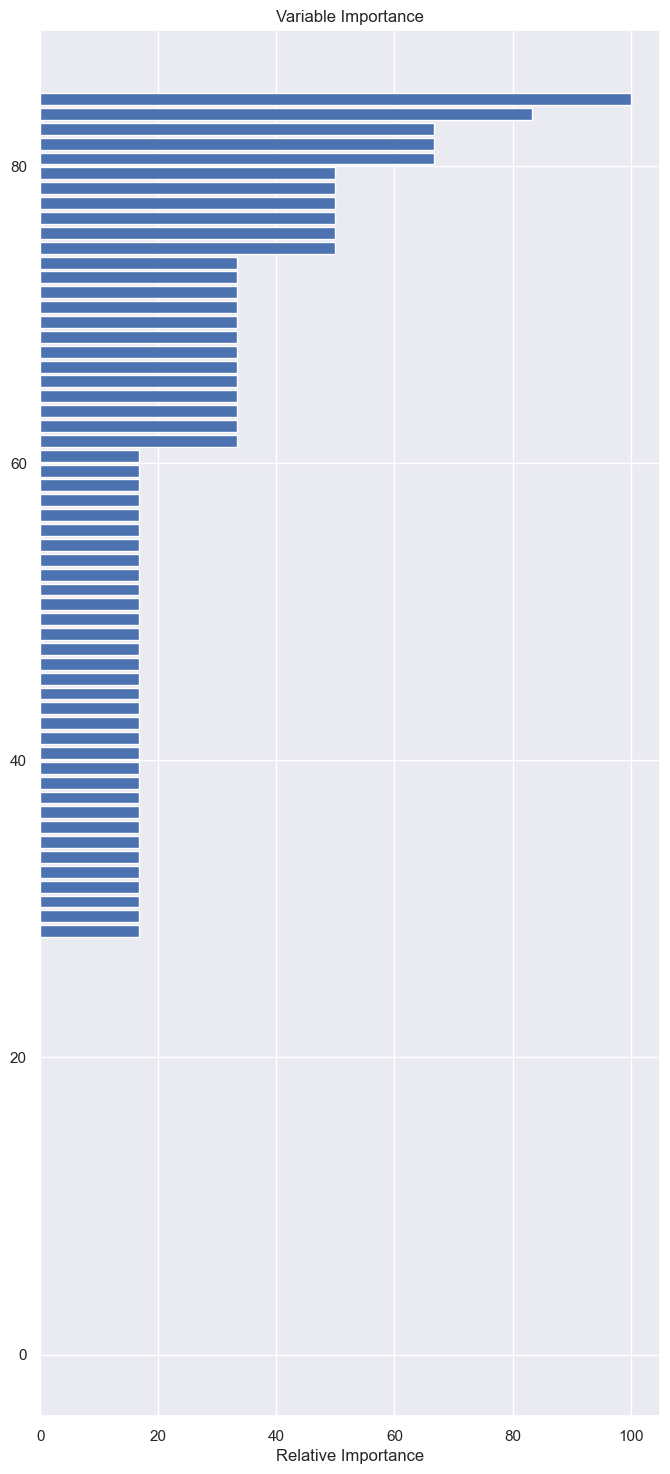

In [185]:
# Plot feature importance
feature_importance = ada.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
#plt.yticks(pos, tr_x.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

**Conslusion:** 

* The given dataset has data from different sensors. But not all were actually required to model it.

* Many sensors had highly correlated values and multi-collinearity issues and were thus removed before model building.

* PCA was also done to remove additional variables that did not have high variance.
* Various algorithms, cross validation technqiues and hyper parameter tuning was done to arrive at the best fitting model.
* The Best Trained Model is Adaboost Classifier for this kind of data.